## Setup

### Import Modules

In [ ]:
import anndata
import numpy as np
import pandas as p
import seaborn as sns
from scipy import stats
import liana as li
import scanpy as sc
import cell2cell as c2c
import decoupler as dc # needed for pathway analysis
from collections import defaultdict
import pickle
import torch
import io
import plotnine as p9
import decoupler as dc # needed for pathway analysis
#from statannotations.Annotator import Annotator
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean
import os
import omnipath as op
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from io import BytesIO
import PIL.Image
from typing import Callable
from pathlib import Path
import contextlib
import os
import sys


In [ ]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 80, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.6
-----
PIL                 10.4.0
asttokens           NA
attr                23.2.0
backcall            0.2.0
brotli              1.1.0
cell2cell           0.7.4
certifi             2024.06.02
cffi                1.16.0
charset_normalizer  3.3.2
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.2
decorator           5.1.1
decoupler           1.6.0
docrep              0.3.2
et_xmlfile          1.1.0
executing           2.0.1
fontTools           4.53.0
get_annotations     NA
gseapy              1.0.3
h5py                3.11.0
idna                3.7
importlib_resources NA
inflect             NA
ipykernel           6.29.5
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
kneed               0.8.5
liana               1.2.1
llvmlite            0.41.1
matplotlib          3.7.5
matplotlib_inline   0.1.7
mizani              0.9.3
more_itertools     

### Helper Functions

In [115]:
def save_plot_to_buffer(plot_func, *args, **kwargs):
    buf = BytesIO()
    plot_func(*args, **kwargs)
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()
    return buf

def unpickle_gpu_tensor(filepath: str, processing_unit: str):
    '''
    Function to load a pickled tensor file created using cell2cell with gpu acceleration

    filepath: str = path of the tensor file
    processing_unit: str = processing_unit used in the current environment to load the file onto (either "gpu" or "cpu")
    '''
    class CPU_Unpickler(pickle.Unpickler):
        def find_class(self, module, name):
            if module == 'torch.storage' and name == '_load_from_bytes':
                return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
            else: return super().find_class(module, name)

    processing_unit_values = ['cpu', 'gpu']
    if processing_unit == 'cpu':
        with open(filepath, 'rb') as f:
            tensor = CPU_Unpickler(f).load()
    elif processing_unit == 'gpu':
        with open(filepath, 'rb') as f:
            tensor = pickle.load(f)
    else:
        raise ValueError(f'accelerator must be one of {processing_unit_values}')
    return tensor


def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0.0  
    return dot_product / (norm_vec1 * norm_vec2)

def find_outlier_vectors(
        df: pd.DataFrame,
        col_vec: bool=True,
        normalize_df: bool=True,
        aggregate_func: Callable=np.mean,
        **aggregate_func_argument
):
    if col_vec:
        df = df.T
    if normalize_df:
        df = df.div(df.sum(axis=1), axis=0)
    similarity_matrix = pairwise.cosine_similarity(df)
    np.fill_diagonal(similarity_matrix, 0)
    aggregated_similarity = aggregate_func(similarity_matrix, **aggregate_func_argument)
    indices = df.index[np.argsort(aggregated_similarity)]
    values = np.sort(aggregated_similarity)
    return pd.DataFrame(data=values, index=indices)

def get_tensor_factors(
    tensor: c2c.tensor.PreBuiltTensor
) -> list:
    return list(tensor.factors['Contexts'].columns)

def check_factor_completion(
        factor_df: pd.DataFrame,
        cell_types: set
):
    difference = cell_types.difference(factor_df.index)
    if difference:
        for cell_type in difference:
            factor_df.loc[cell_type] = np.zeros(factor_df.shape[1], dtype=np.float32)
    factor_df = factor_df.sort_index()
    return factor_df

def get_tensor_signalling_arrays(
        tensor: c2c.tensor.PreBuiltTensor,
        cell_types: set,
) -> dict:
    tensor_factors = get_tensor_factors(tensor)
    tensor_signalling_arrays = {}
    for factor in tensor_factors:
        sender_df = check_factor_completion(
            tensor.factors['Sender Cells'],
            cell_types
        )
        receiver_df = check_factor_completion(
            tensor.factors['Receiver Cells'],
            cell_types
        )
        sender_cell_array = sender_df[factor].to_numpy()
        receiver_cell_array = receiver_df[factor].to_numpy()
        tensor_signalling_arrays[factor] = np.concatenate(
            (
                sender_cell_array,
                receiver_cell_array
            )
        )
    return tensor_signalling_arrays

def find_mutual_best_fits(
        tensor_1_signalling_arrays: dict,
        tensor_2_signalling_arrays: dict
) -> dict:
    best_fits_1_to_2 = {}
    for factor1, array1 in tensor_1_signalling_arrays.items():
        best_match = None
        highest_similarity = -1
        for factor2, array2 in tensor_2_signalling_arrays.items():
            similarity = cosine_similarity(array1, array2)
            if similarity > highest_similarity:
                highest_similarity = similarity
                best_match = factor2
        best_fits_1_to_2[factor1] = best_match

    best_fits_2_to_1 = {}
    for factor2, array2 in tensor_2_signalling_arrays.items():
        best_match = None
        highest_similarity = -1
        for factor1, array1 in tensor_1_signalling_arrays.items():
            similarity = cosine_similarity(array2, array1)
            if similarity > highest_similarity:
                highest_similarity = similarity
                best_match = factor1
        best_fits_2_to_1[factor2] = best_match

    mutual_best_fits = {}
    for factor1, best_fit_factor2 in best_fits_1_to_2.items():
        if best_fits_2_to_1.get(best_fit_factor2) == factor1:
            mutual_best_fits[factor1] = best_fit_factor2

    return mutual_best_fits

def return_sender_receiver_factor_df(
        tensor: c2c.tensor.PreBuiltTensor,
        cell_types: set,
        factor_condition: str = None
) -> pd.DataFrame:
    sender_df: pd.DataFrame = check_factor_completion(tensor.factors['Sender Cells'], cell_types)
    sender_df.index = ['sender_' + index for index in sender_df.index]
    receiver_df: pd.DataFrame = check_factor_completion(tensor.factors['Sender Cells'], cell_types)
    receiver_df.index = ['receiver_' + index for index in receiver_df.index]
    sender_receiver_df = pd.concat(
        [
            sender_df,
            receiver_df
        ]
    )
    sender_receiver_df.columns = [f'{factor_condition}_' + column for column in sender_receiver_df.columns]
    return sender_receiver_df

def GSEA_enrichment_analysis(
        tensor,
        condition,
        figures_dir,
        organism: str='human',
        pathwaydb: str='Reactome'
):
    pathway_label = '{} Annotations'.format(pathwaydb)
    lr_loadings = tensor.factors['Ligand-Receptor Pairs']
    lr_list = ['^'.join(row) for idx, row in lr_pairs.iterrows()]
    output_folder = figures_dir / 'GSEA'
    output_folder.mkdir(exist_ok=True)
    fig_filename = output_folder / f'GSEA-{condition}-Dotplot.pdf'
    lr_set = c2c.external.generate_lr_geneset(
        lr_list,
        complex_sep='_',
        lr_sep='^',
        organism=organism,
        pathwaydb=pathwaydb,
        readable_name=True,
    )
    pvals, scores, gsea_df = c2c.external.run_gsea(
        loadings=lr_loadings,
        lr_set=lr_set,
        output_folder=str(output_folder),
        weight=1,
        min_size=15,
        permutations=999,
        processes=6,
        random_state=6,
        significance_threshold=0.05,
    )
    with sns.axes_style("darkgrid"):
        dotplot = c2c.plotting.pval_plot.generate_dot_plot(
            pval_df=pvals,
            score_df=scores,
            significance=0.08,
            xlabel='',
            ylabel=pathway_label,
            cbar_title='NES',
            cmap='PuOr',
            figsize=(20, 12),
            label_size=20,
            title_size=20,
            tick_size=12,
            filename=str(fig_filename)
        )
    
    plt.suptitle(f"GSEA Dotplot Analysis {condition}", fontsize=22, y=0.97) 
    plt.tight_layout()
    print(condition)
    plt.show()

def factor_pathway_loadings(
        tensor,
        condition,
        pathway,
        factor,
        lr_progeny,
        save_file,
):
    lr_loadings = tensor.factors['Ligand-Receptor Pairs']
    lr_loadings_long = lr_loadings.reset_index().melt(id_vars='index', var_name="Factor", value_name="Loadings").rename(columns={'index':'interaction'})
    lr_loadings_long = lr_loadings_long.merge(lr_progeny, on='interaction').query("source == '{}' and Factor == '{}'".format(pathway, factor))
    lr_loadings_long['sign'] = lr_loadings_long['weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
    lr_loadings_long['relevant_interactions'] = lr_loadings_long.apply(lambda x: x['interaction'] if (x['Loadings'] > 0.00025) and (x['weight'] > 2.5) else None, axis=1)
    plot = (p9.ggplot(
        lr_loadings_long,
        p9.aes(x='weight', y='Loadings')) +
        p9.geom_smooth(method='lm') +
        p9.geom_point(p9.aes(colour='sign')) +
        p9.theme_bw() +
        p9.theme(legend_position='none') +
        p9.labs(title="{} | {}".format(pathway, factor), x="PROGENy Weights", y="Loadings") +
        p9.scale_colour_manual(values=["royalblue", "red"]) +
        p9.geom_label(p9.aes(label='relevant_interactions'), size=8, nudge_y=0.01, nudge_x=0.01) +
        p9.xlim(-1, 8.5)
    )
    if save_file != None:
        plot.save(save_file)
    print(plot)

    

### Loading Data

In [ ]:
data_dir = Path.cwd() / '.data'
figures_dir = data_dir / 'figures'
data_dir.mkdir(exist_ok=True)
figures_dir.mkdir(exist_ok=True)

In [74]:
adata_file = data_dir / 'Marburg_cell_states_locked_ctl240709.raw.h5ad' 
adata_all = sc.read_h5ad(adata_file)
adata_all

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'viral_counts', 'infected_status', 'seed_labels', 'batch-scANVI'
    var: 'mt', 'ribo'
    uns: 'cell_compartment_colors', 'cell_states_colors', 'disease_colors', 'group_colors', 'infection_colors'
    obsm: 'X_scANVI', 'X_umap'

In [75]:
sample_key = 'batch'
condition_key = 'infection'
groupby = 'cell_compartment'

context_dict = adata_all.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)
# Generate color by severity for each sample
condition_colors = c2c.plotting.aesthetics.get_colors_from_labels(['CTRL', 'IAV'], cmap='plasma')
# Map these colors to each sample name
color_dict = {k : condition_colors[v] for k, v in context_dict.items()}
col_colors = pd.Series(color_dict)
col_colors = col_colors.to_frame()
col_colors.columns = ['infection status']

In [76]:
'''
Loading the output tensor of liana c2c tensor of healthy and copd subgroups
'''
# Healthy Tensor
file_name = 'final_tensor_compartment_healthy.pkl'
file_path = os.path.join(data_dir, file_name)
tensor_healthy = unpickle_gpu_tensor(file_path, 'cpu')
factors_healthy = tensor_healthy.factors

# COPD Tensor
file_name = 'final_tensor_compartment_COPD.pkl'
file_path = os.path.join(data_dir, file_name)
tensor_COPD = unpickle_gpu_tensor(file_path, 'cpu')
factors_COPD = tensor_COPD.factors

# Storing tensors in dict
tensor_dict = {
    'Healthy': tensor_healthy,
    'COPD': tensor_COPD,
}

In [77]:
'''
Standard cell type palette for plotting
'''
palette={
    'Basal': '#a6cee3',
    'Goblet': '#1f78b4',
    'SupraB': '#b2df8a',
    'Ciliated': '#33a02c',
    'Mixed': '#fb9a99',
    'Secretory': '#e31a1c',
    'Club': '#fdbf6f',
    'Deuterosomal': '#ff7f00',
    'Ionocyte': '#cab2d6',
    'Epi': '#6a3d9a',
}

## Analysis

### Determining mutual best fit factors from both conditions

In [78]:
cell_types = set(adata_all.obs['cell_compartment'])
signalling_array_dict = {condition: get_tensor_signalling_arrays(
    tensor=tensor,
    cell_types=cell_types
) for condition, tensor in tensor_dict.items()}
mutual_best_fits = find_mutual_best_fits(
    signalling_array_dict['Healthy'],
    signalling_array_dict['COPD'],
)
mutual_best_fits

{'Factor 1': 'Factor 1',
 'Factor 2': 'Factor 7',
 'Factor 3': 'Factor 2',
 'Factor 4': 'Factor 5',
 'Factor 6': 'Factor 4',
 'Factor 7': 'Factor 8'}

### Tensor Loading Clustermap

Healthy


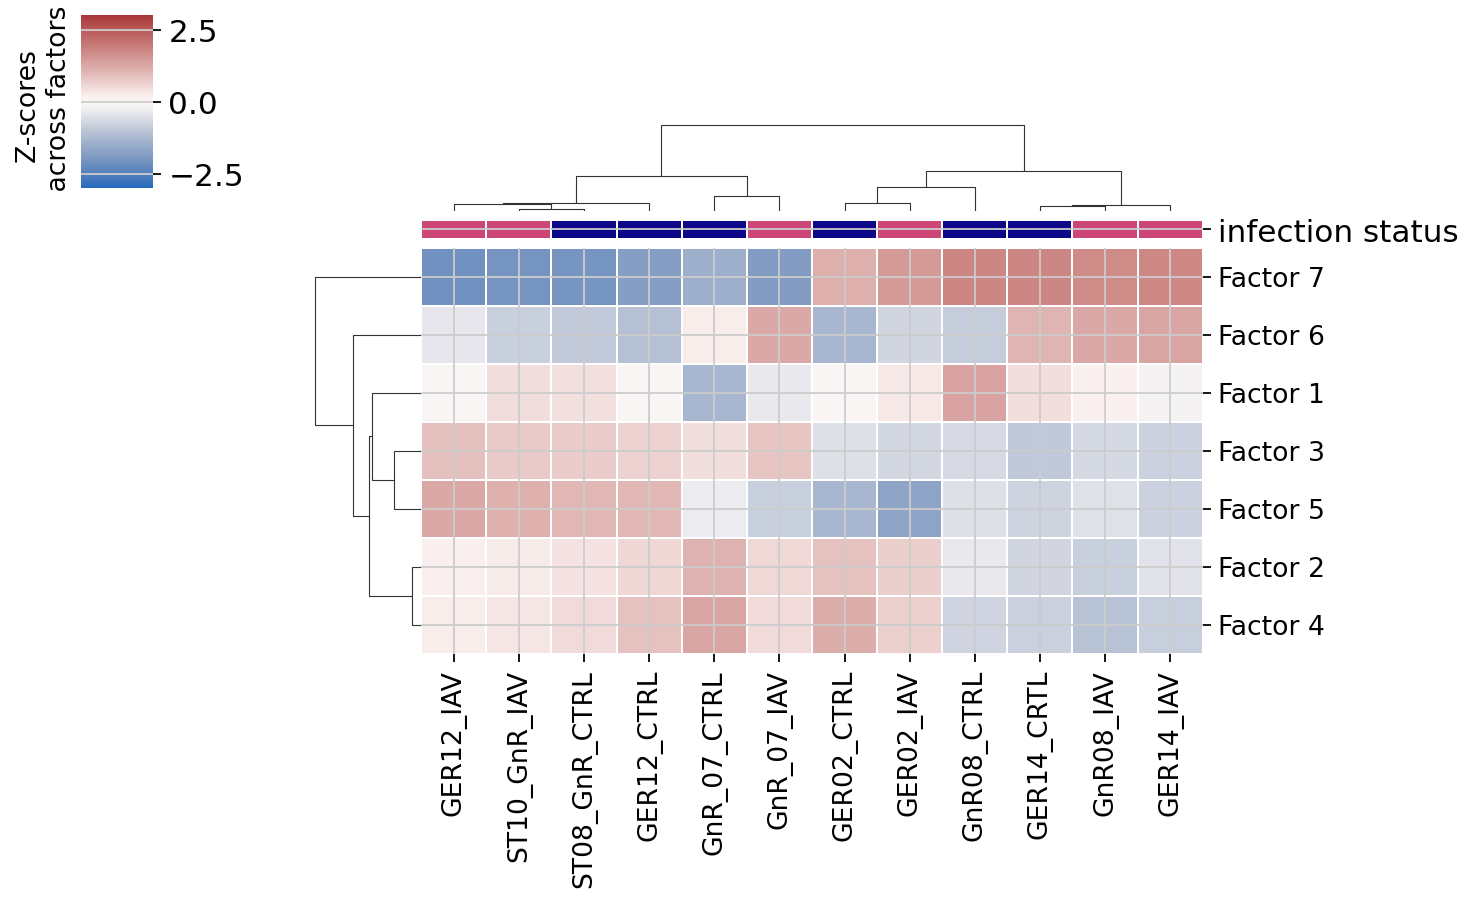

COPD


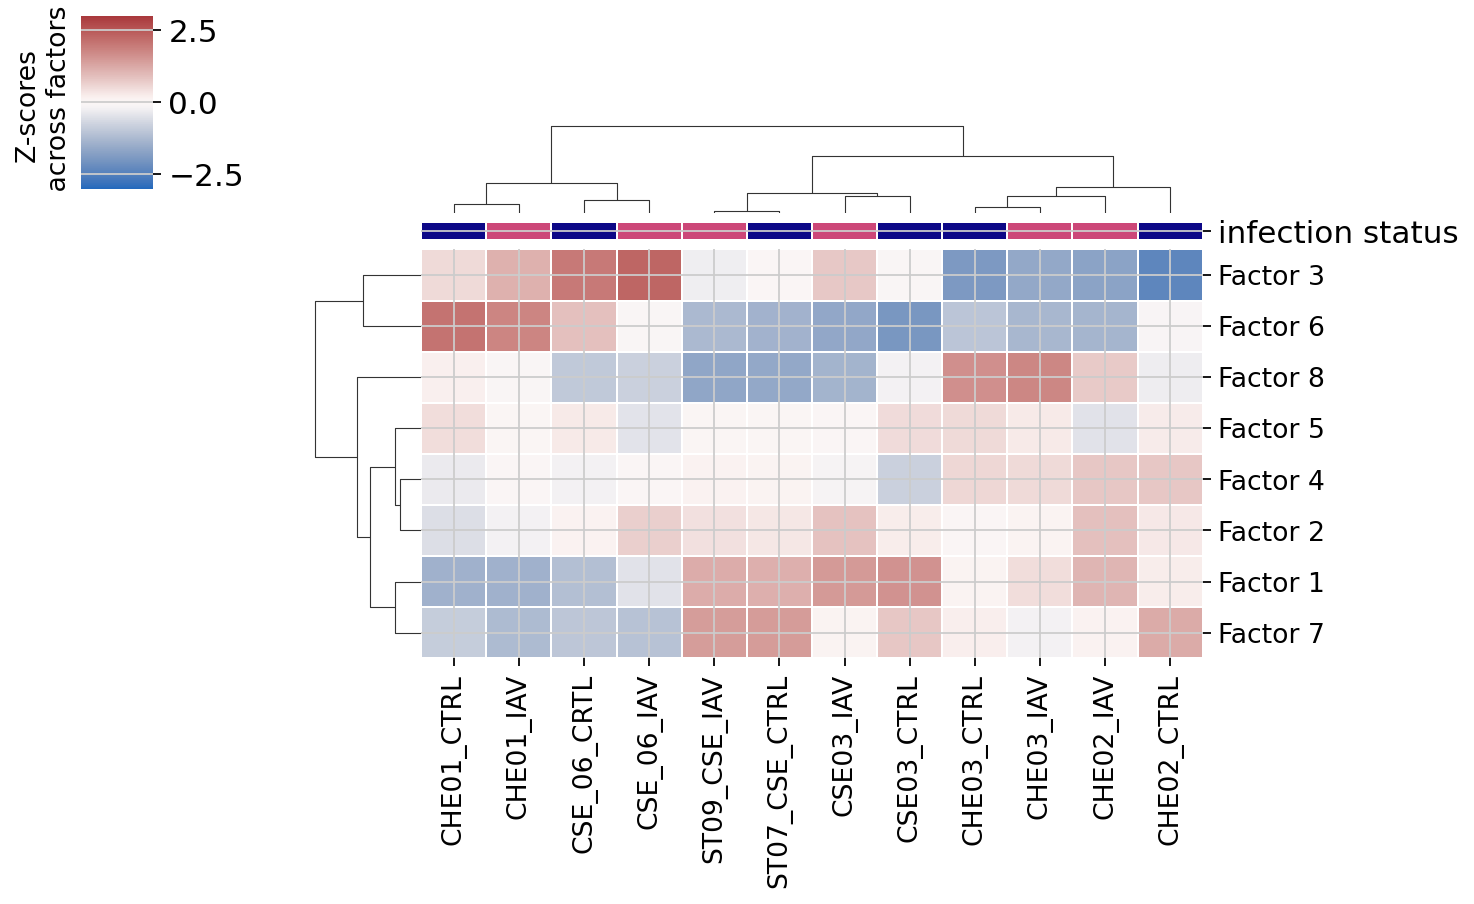

In [79]:
for condition, tensor in tensor_dict.items():
    c2c.plotting.loading_clustermap(
        tensor.factors['Contexts'],
        use_zscore=True,
        col_colors=col_colors,
        figsize=(9, 6),
        dendrogram_ratio=0.3,
        cbar_fontsize=12,
        tick_fontsize=12
    )
    output_dir = figures_dir / 'clustermap'
    output_dir.mkdir(exist_ok=True)
    plt.savefig(output_dir / f'clustermap_{condition}.svg')
    print(condition)
    plt.show()

### Compartments Barplot

{'Factor 1': 'Factor 1', 'Factor 2': 'Factor 7', 'Factor 3': 'Factor 2', 'Factor 4': 'Factor 5', 'Factor 6': 'Factor 4', 'Factor 7': 'Factor 8'}
Healthy


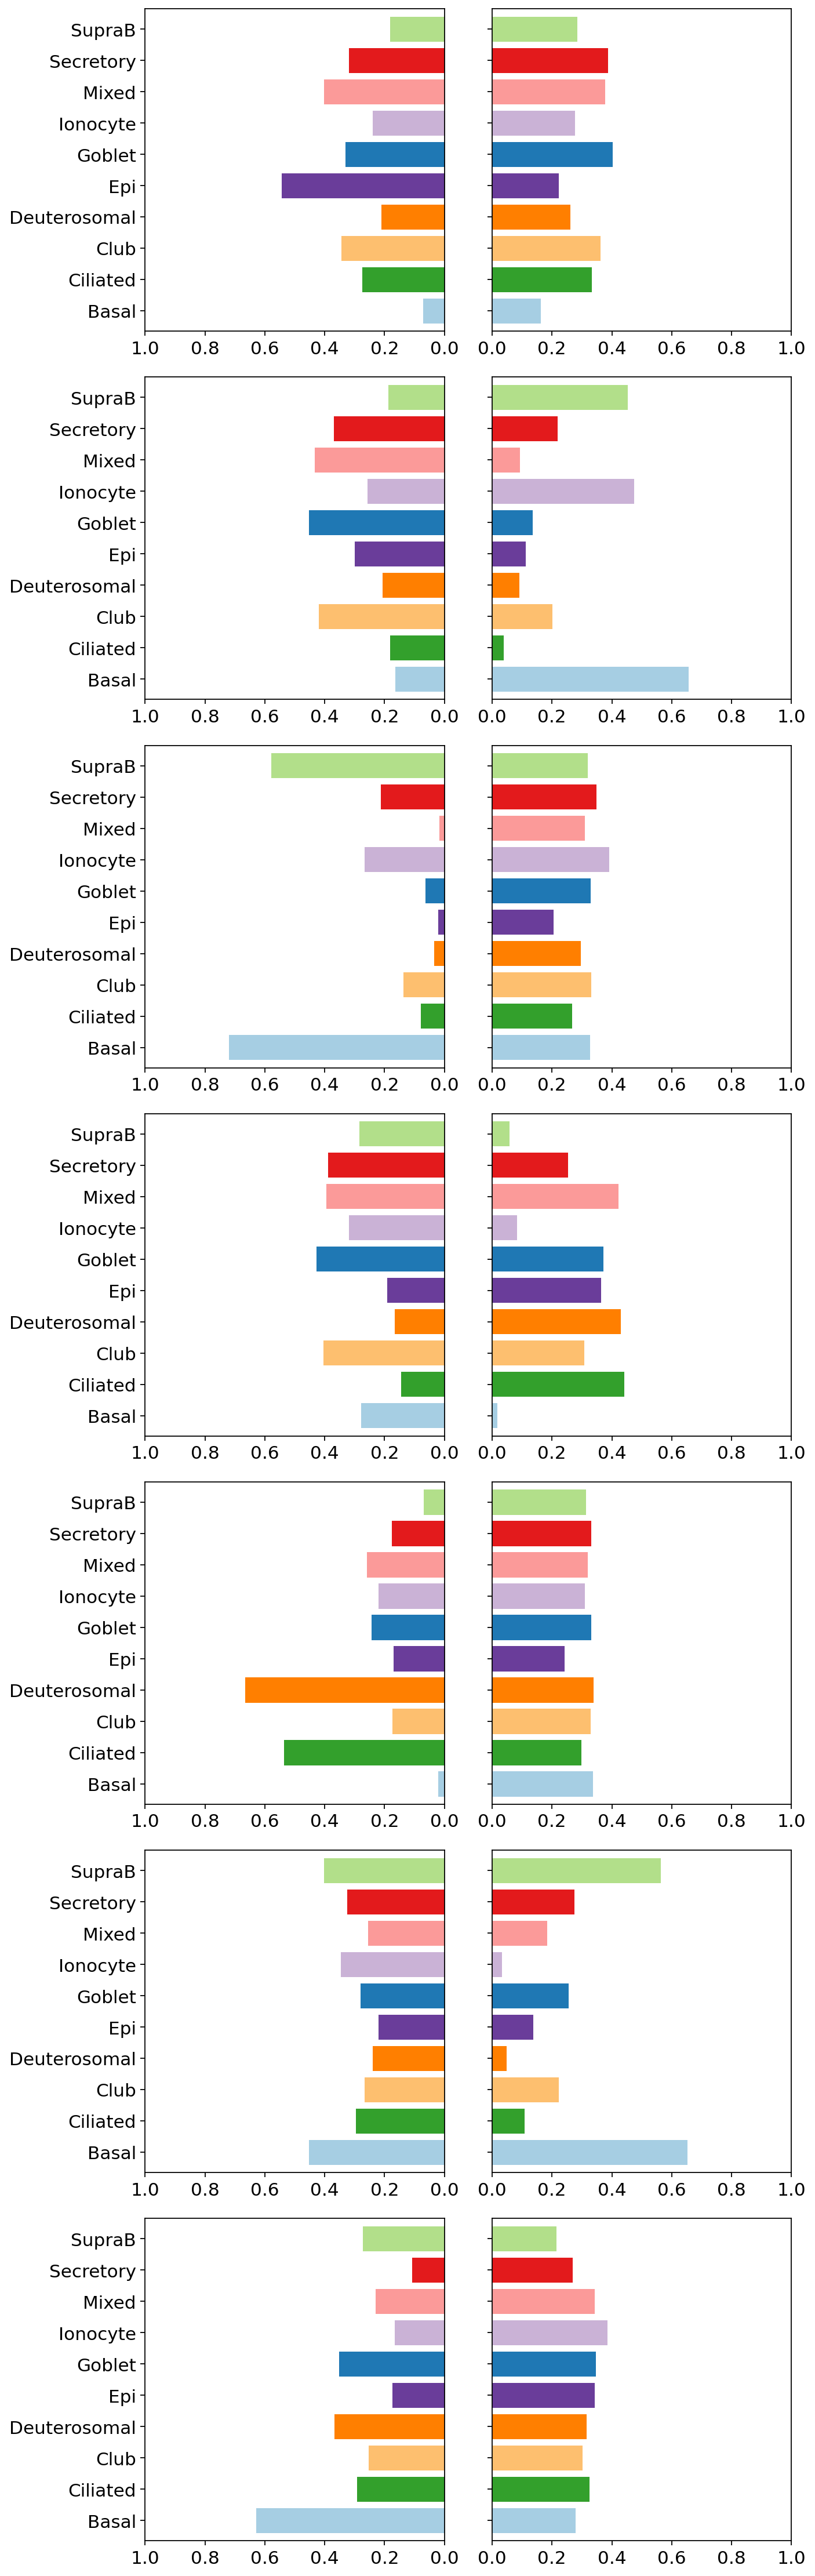

COPD


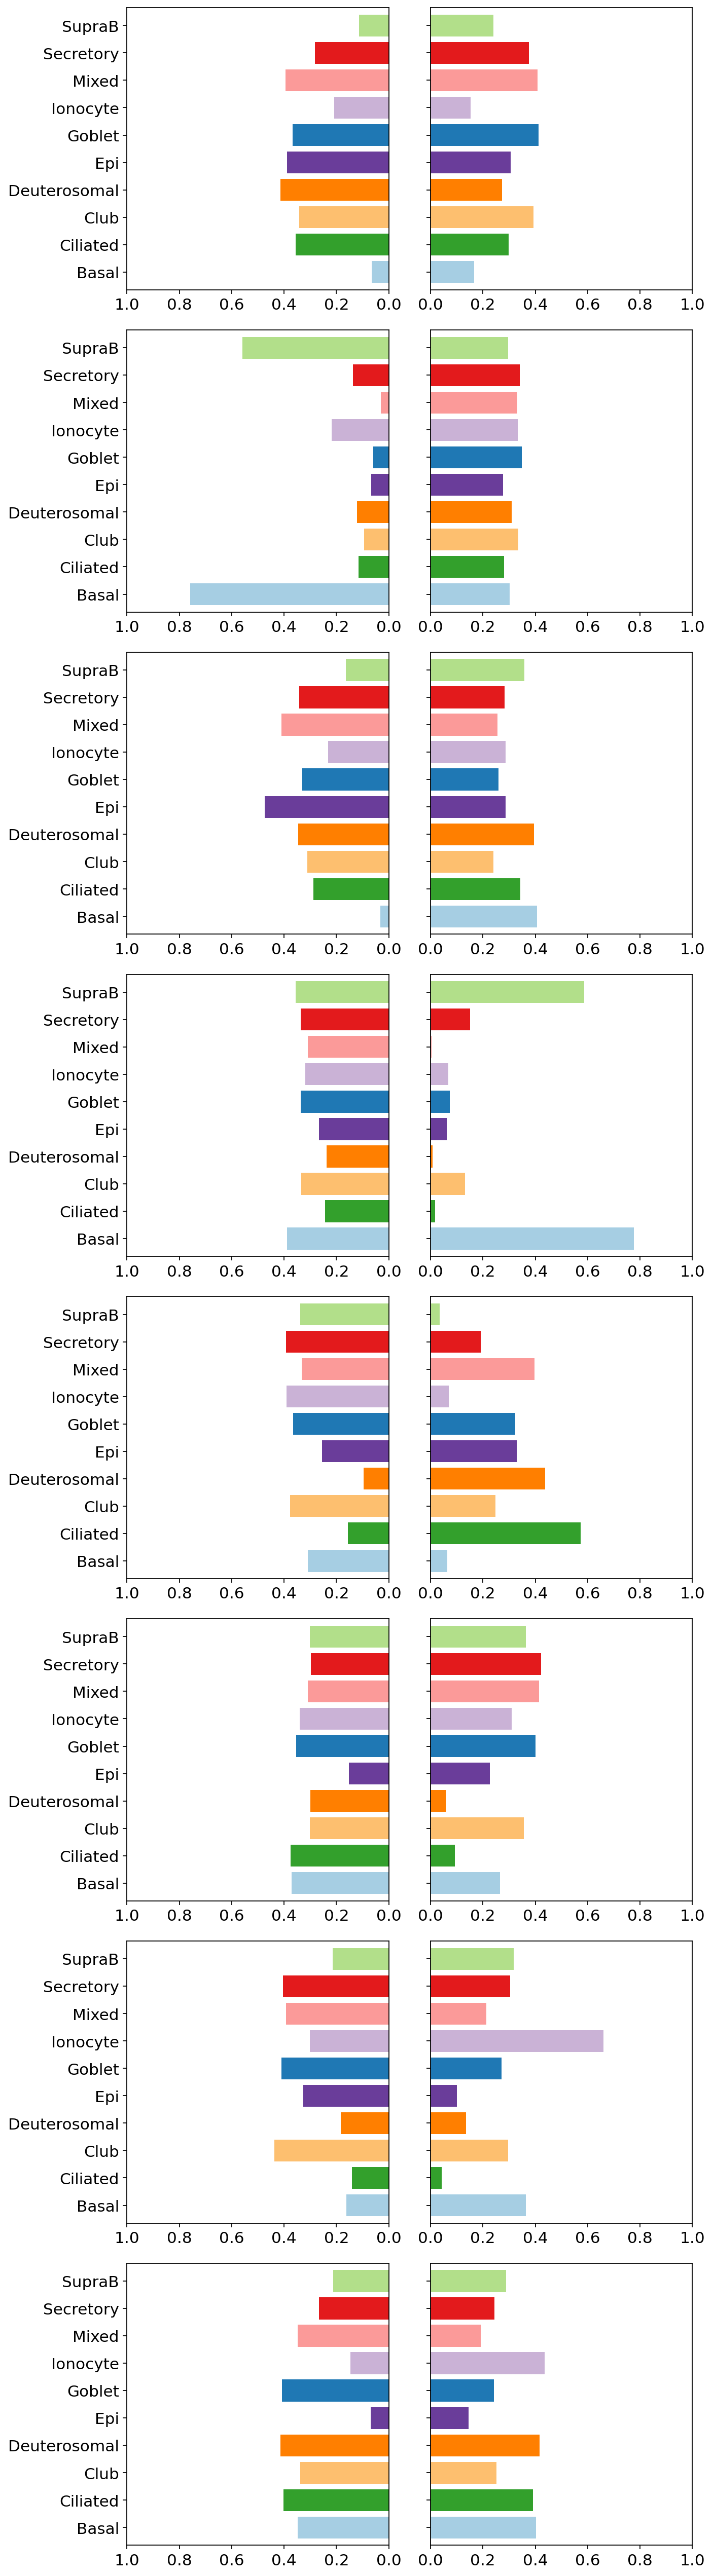

In [80]:
print(mutual_best_fits)
for condition, tensor in tensor_dict.items():
    factors = list(tensor.factors['Contexts'].columns)
    n_factors = len(factors)
    fig, axes = plt.subplots(n_factors, 2, figsize=(9, 4 * n_factors), sharey=True)
    colors = [palette[sender] for sender in tensor.factors['Receiver Cells'].index]
    width = 0.8
    for i, factor in enumerate(factors):
        tensor.factors['Sender Cells'][factor].plot(kind='barh', color=colors, ax=axes[i, 0], width=width)
        axes[i, 0].invert_xaxis()
        axes[i, 0].grid(False)
        tensor.factors['Receiver Cells'][factor].plot(kind='barh', color=colors, ax=axes[i, 1], width=width)
        axes[i, 0].set_xlim(1, 0)
        axes[i, 1].set_xlim(0, 1)
        axes[i, 1].grid(False)
    output_dir = figures_dir / 'compartments_barplots'
    output_dir.mkdir(exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_dir / f'compartment_barplot_{condition}.svg')
    print(condition)
    plt.show()

### Context Boxplots

Healthy


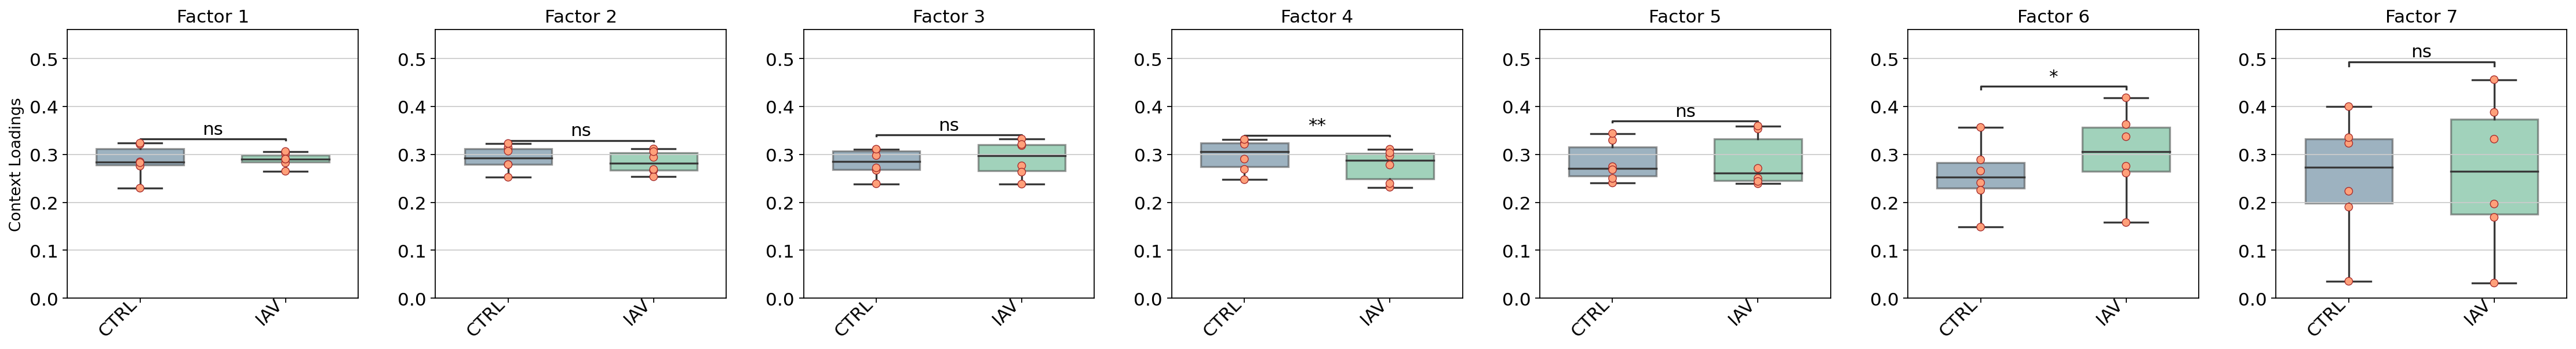

COPD


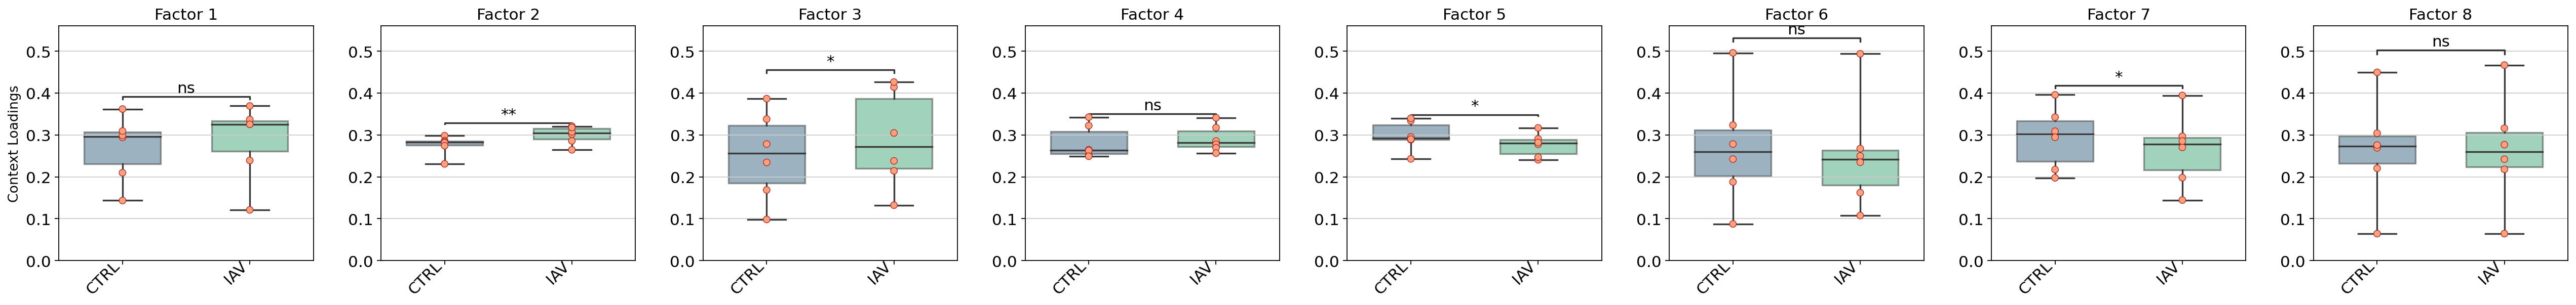

In [81]:
for condition, tensor in tensor_dict.items():
    n_factors = len(list(tensor.factors['Contexts'].columns))
    fig = c2c.plotting.factor_plot.context_boxplot(
        tensor.factors['Contexts'],
        metadict=context_dict,
        group_label_rotation=45,
        nrows=1,
        figsize=(n_factors * 4, 4),
        group_order=['CTRL', 'IAV'],
        statistical_test='t-test_paired',
        pval_correction='BH',
        verbose=False,
        cmap='viridis',
        ylabel="Context Loadings",
        text_format='star'
    )
    for ax in fig[0].axes:
        ax.set_ylim(0, 0.56)  # Set y-axis limits from 0 to 0.5
    output_dir = figures_dir / 'context_boxplots'
    output_dir.mkdir(exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_dir / f'context_boxplots_{condition}.svg')
    print(condition)
    plt.show()

In [174]:
healthy_pairing = {
    'CTRL': [
        'GER02_CTRL',
        'GER12_CTRL',
        'GER14_CRTL',
        'GnR08_CTRL',
        'GnR_07_CTRL',
        'ST08_GnR_CTRL',
    ],
    'IAV': [
        'GER02_IAV',
        'GER12_IAV',
        'GER14_IAV',
        'GnR08_IAV',
        'GnR_07_IAV',
        'ST10_GnR_IAV',
    ]
}
copd_pairing = {
    'CTRL': [
        'CHE01_CTRL',
        'CHE02_CTRL',
        'CHE03_CTRL',
        'CSE03_CTRL',
        'CSE_06_CRTL',
        'ST07_CSE_CTRL',
    ],
    'IAV': [
        'CHE01_IAV',
        'CHE02_IAV',
        'CHE03_IAV',
        'CSE03_IAV',
        'CSE_06_IAV',
        'ST09_CSE_IAV',
    ]
}

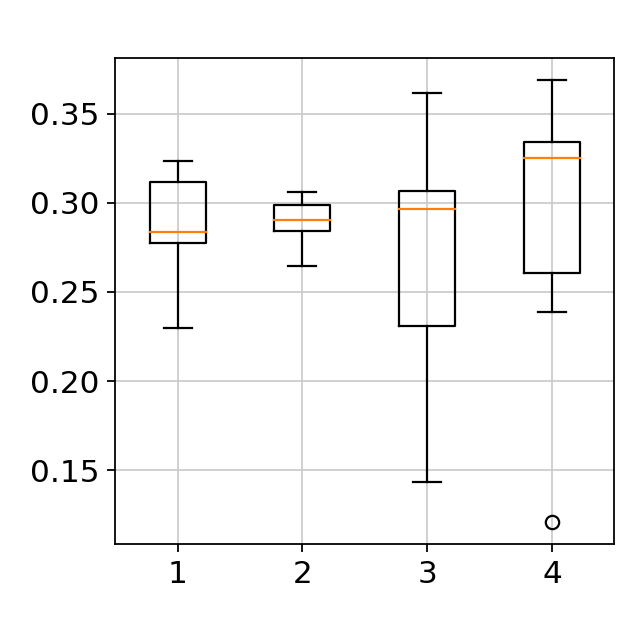

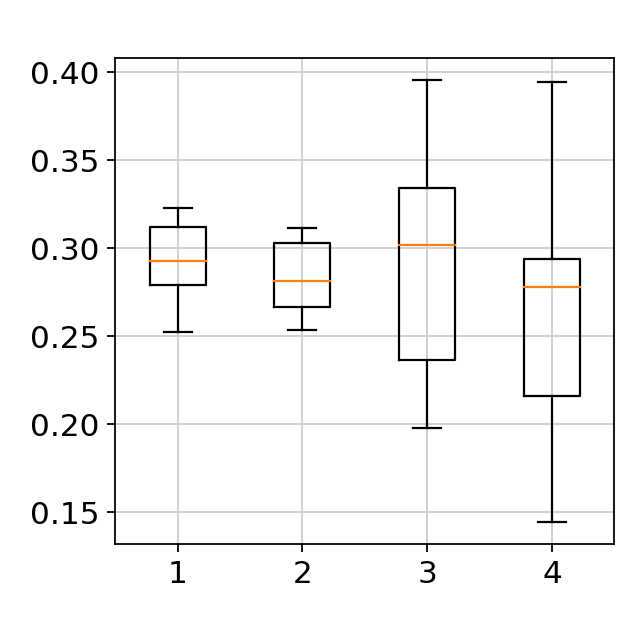

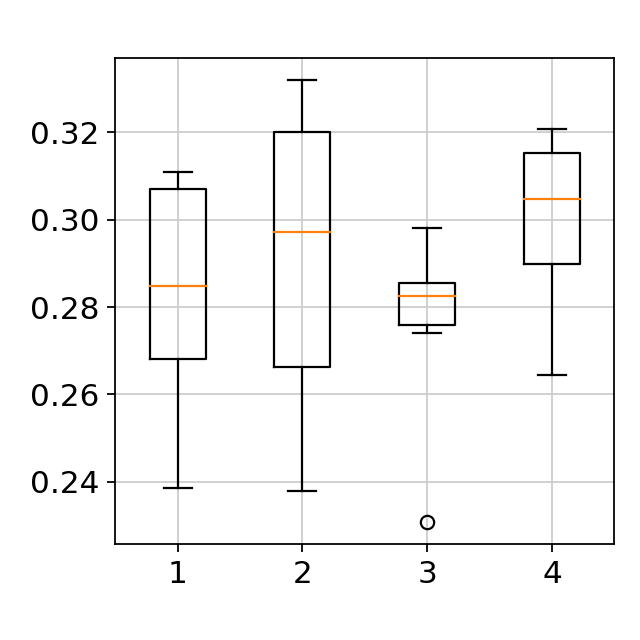

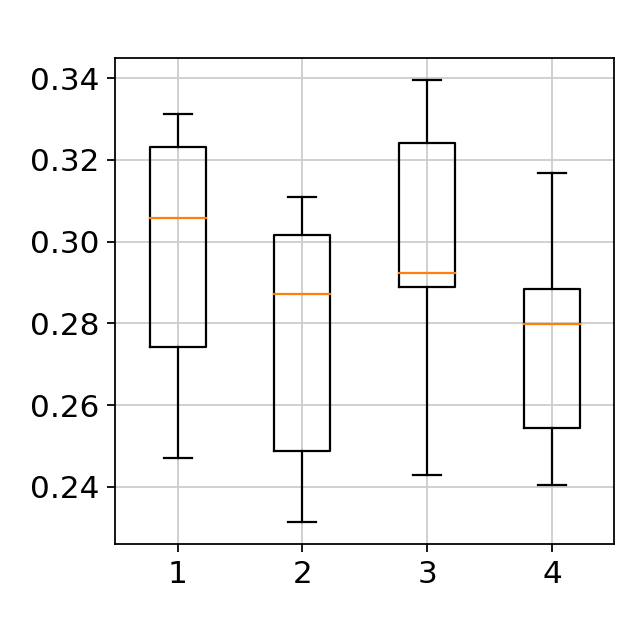

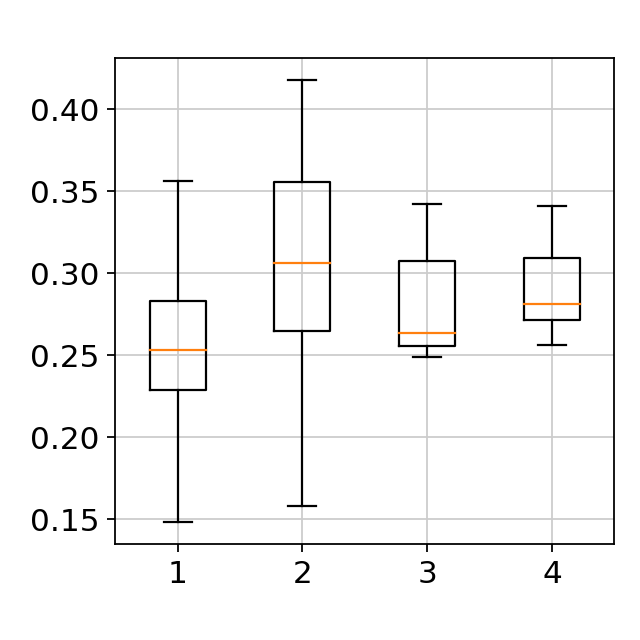

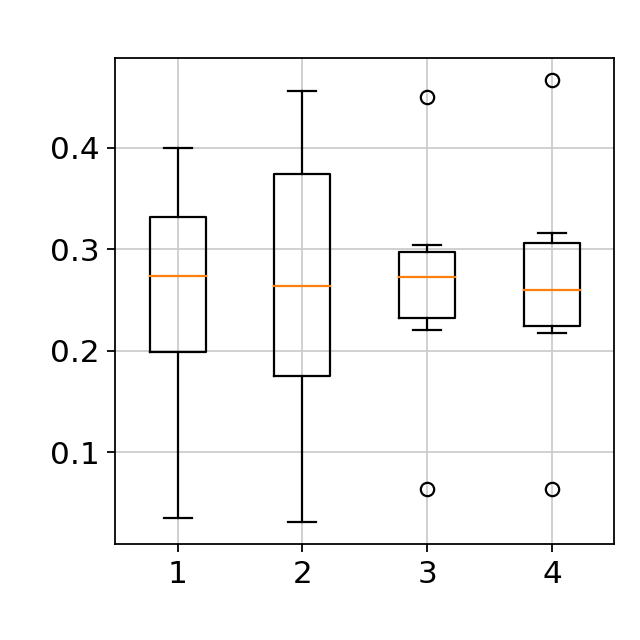

In [182]:
for healthy_factor, copd_factor in mutual_best_fits.items():
    df = pd.concat(
        [
           tensor_dict['Healthy'].factors['Contexts'].loc[healthy_pairing['CTRL']][healthy_factor].reset_index(drop=True),
           tensor_dict['Healthy'].factors['Contexts'].loc[healthy_pairing['IAV']][healthy_factor].reset_index(drop=True),
           tensor_dict['COPD'].factors['Contexts'].loc[copd_pairing['CTRL']][copd_factor].reset_index(drop=True),
           tensor_dict['COPD'].factors['Contexts'].loc[copd_pairing['IAV']][copd_factor].reset_index(drop=True),
        ], 
        axis=1
    )
    plt.boxplot(df)
    plt.show()


### CCC Networks Plot

Healthy


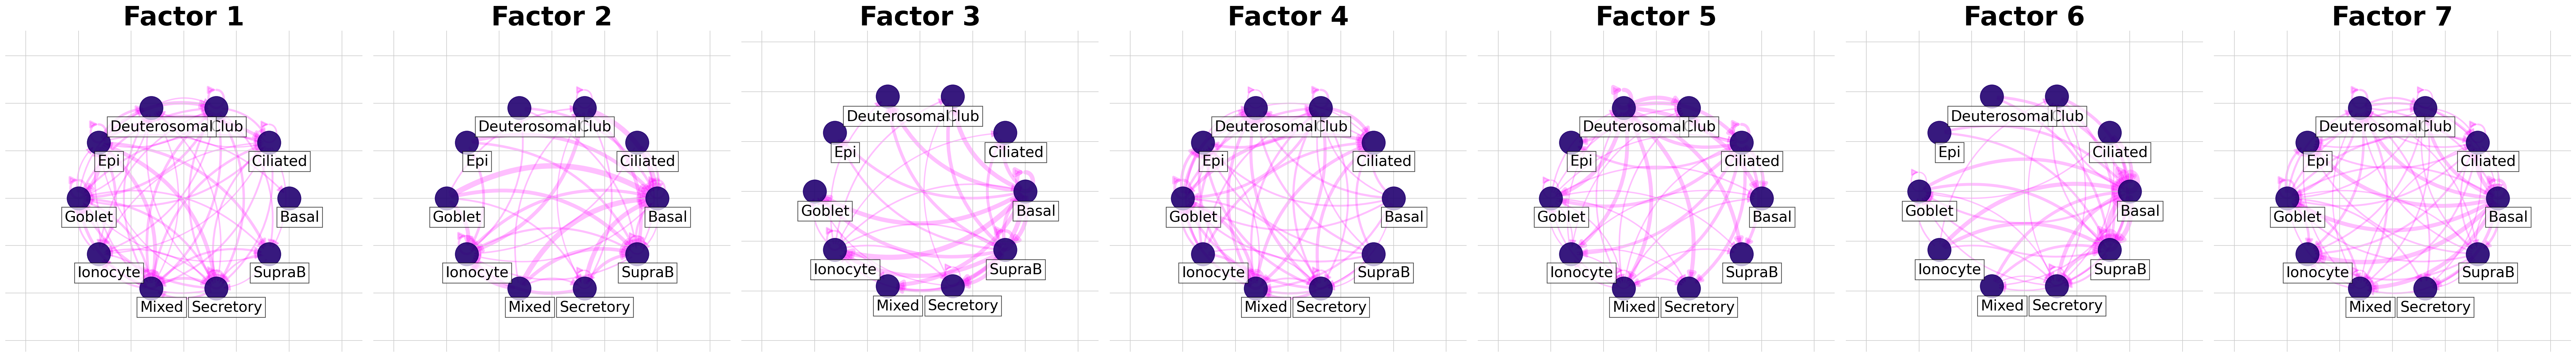

COPD


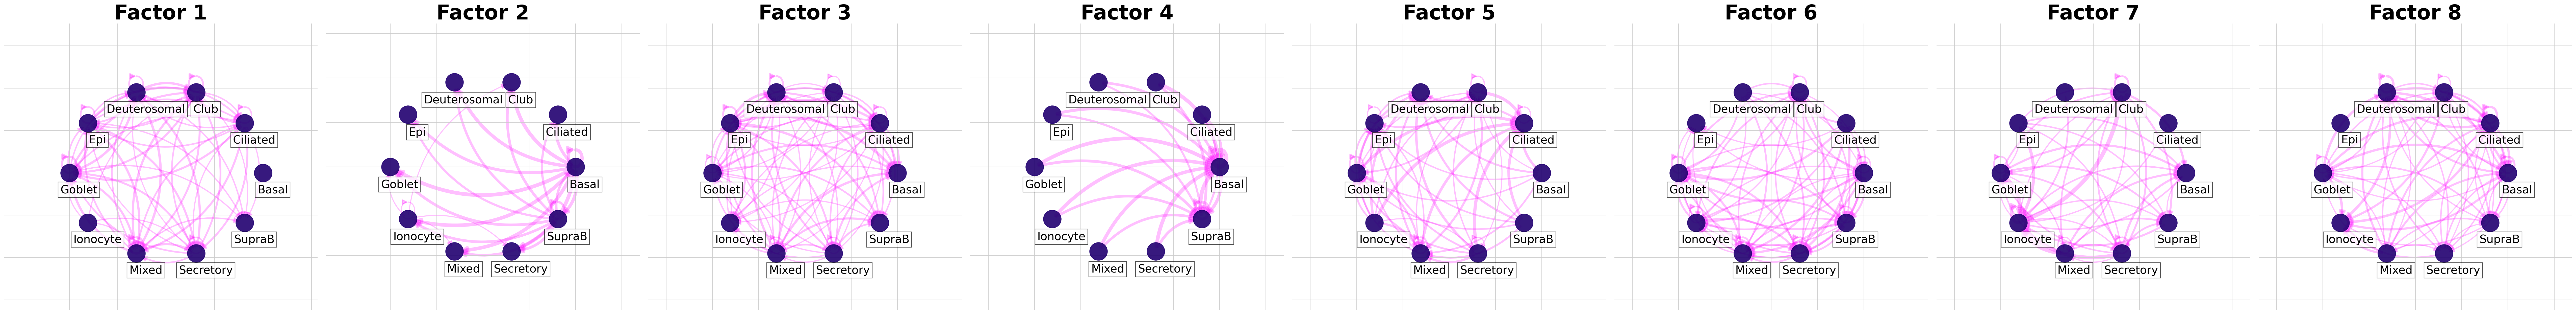

In [82]:

for condition, tensor in tensor_dict.items():
    n_factors = len(list(tensor.factors['Contexts'].columns))
    c2c.plotting.ccc_networks_plot(
        tensor.factors,
        included_factors=[factor for factor in list(tensor.factors['Contexts'].columns)],
        network_layout='circular',
        ccc_threshold=0.07,
        nrows=1,
        panel_size=(n_factors, n_factors),
    )
    output_dir = figures_dir / 'ccc_networks_plot'
    output_dir.mkdir(exist_ok=True)
    plt.tight_layout()
    plt.savefig(output_dir / f'ccc_networks_plot_{condition}.svg')
    print(condition)
    plt.show()

### LR Loadings Plots

Healthy


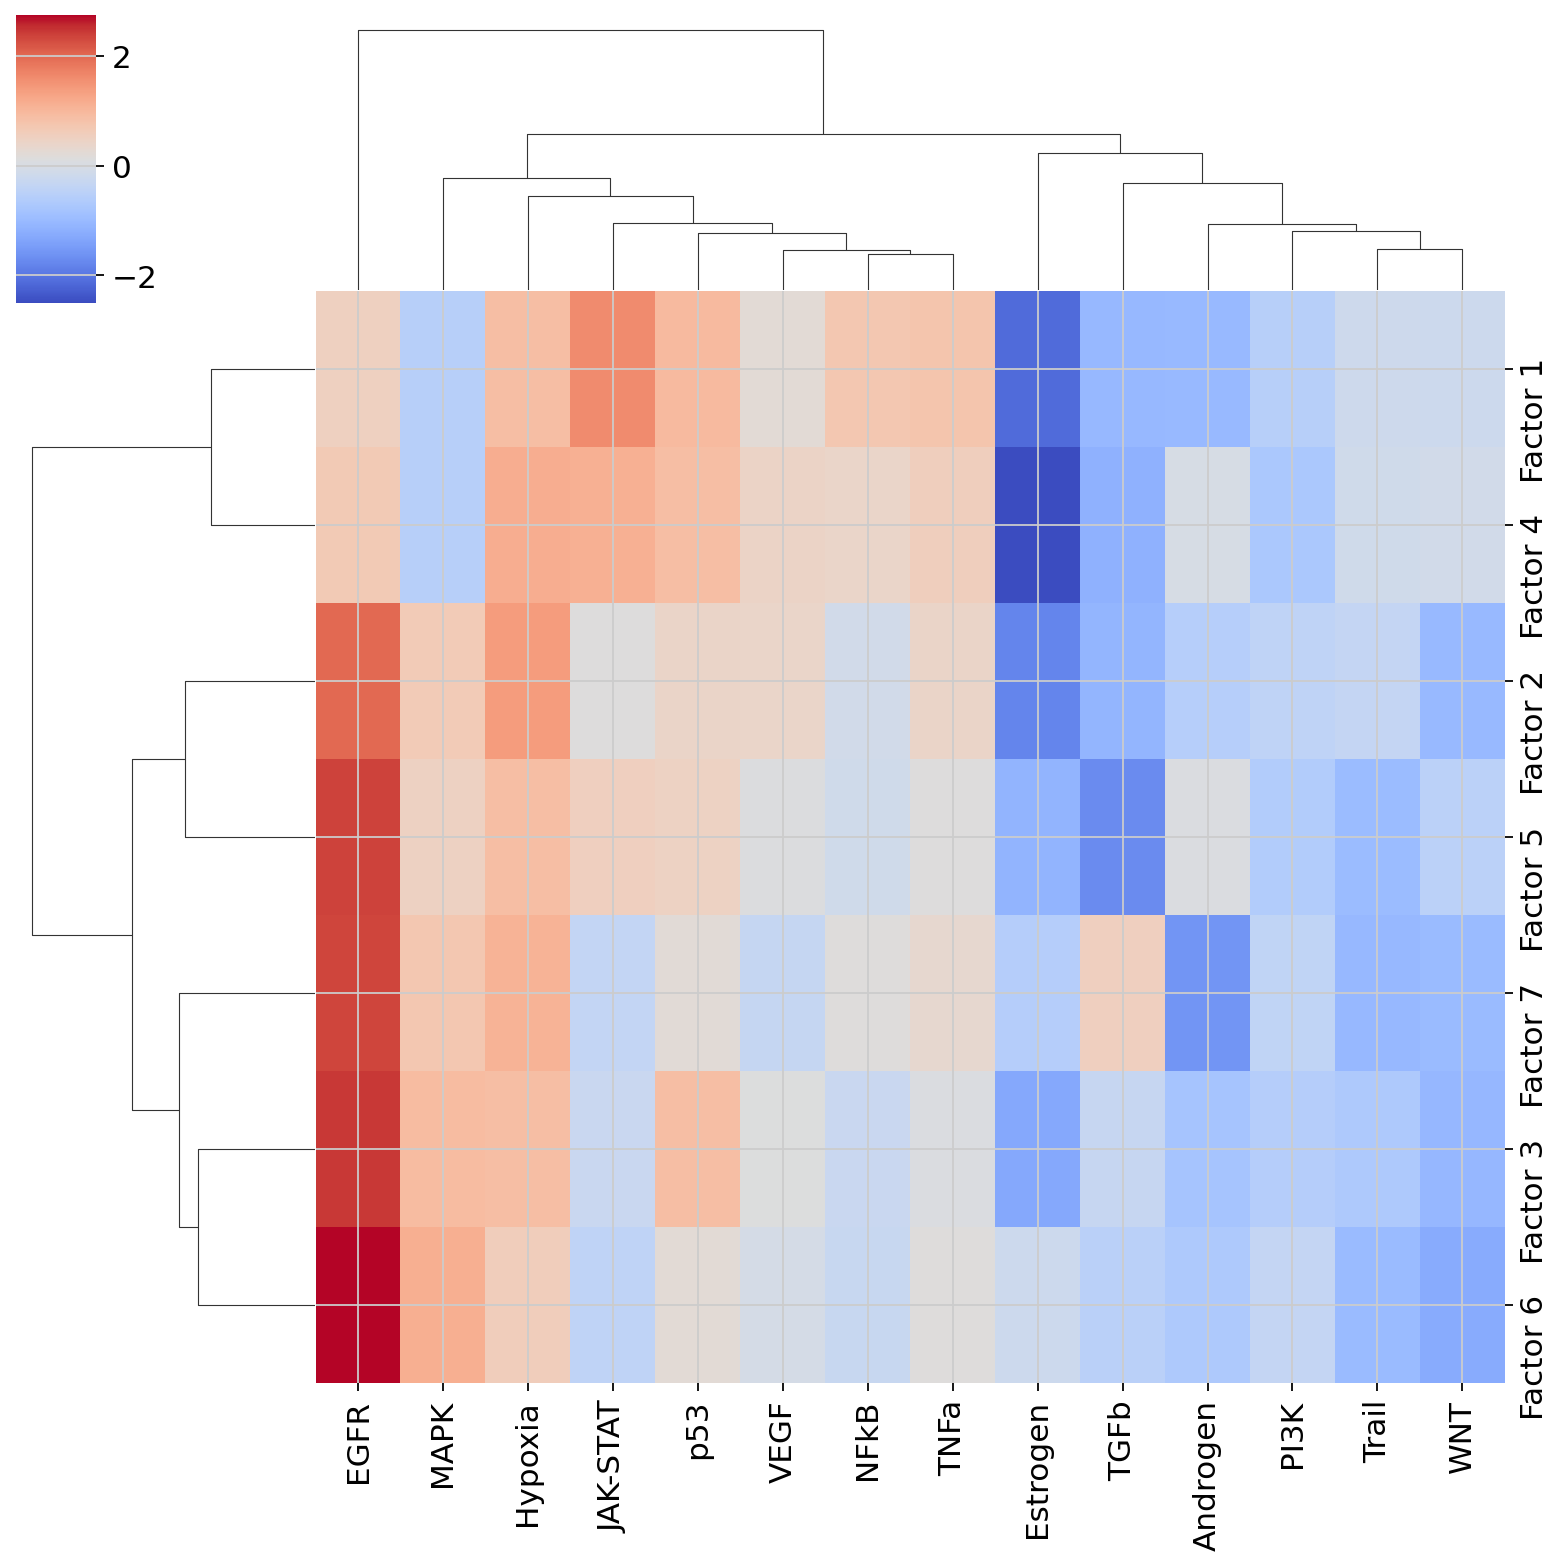

Factor 1


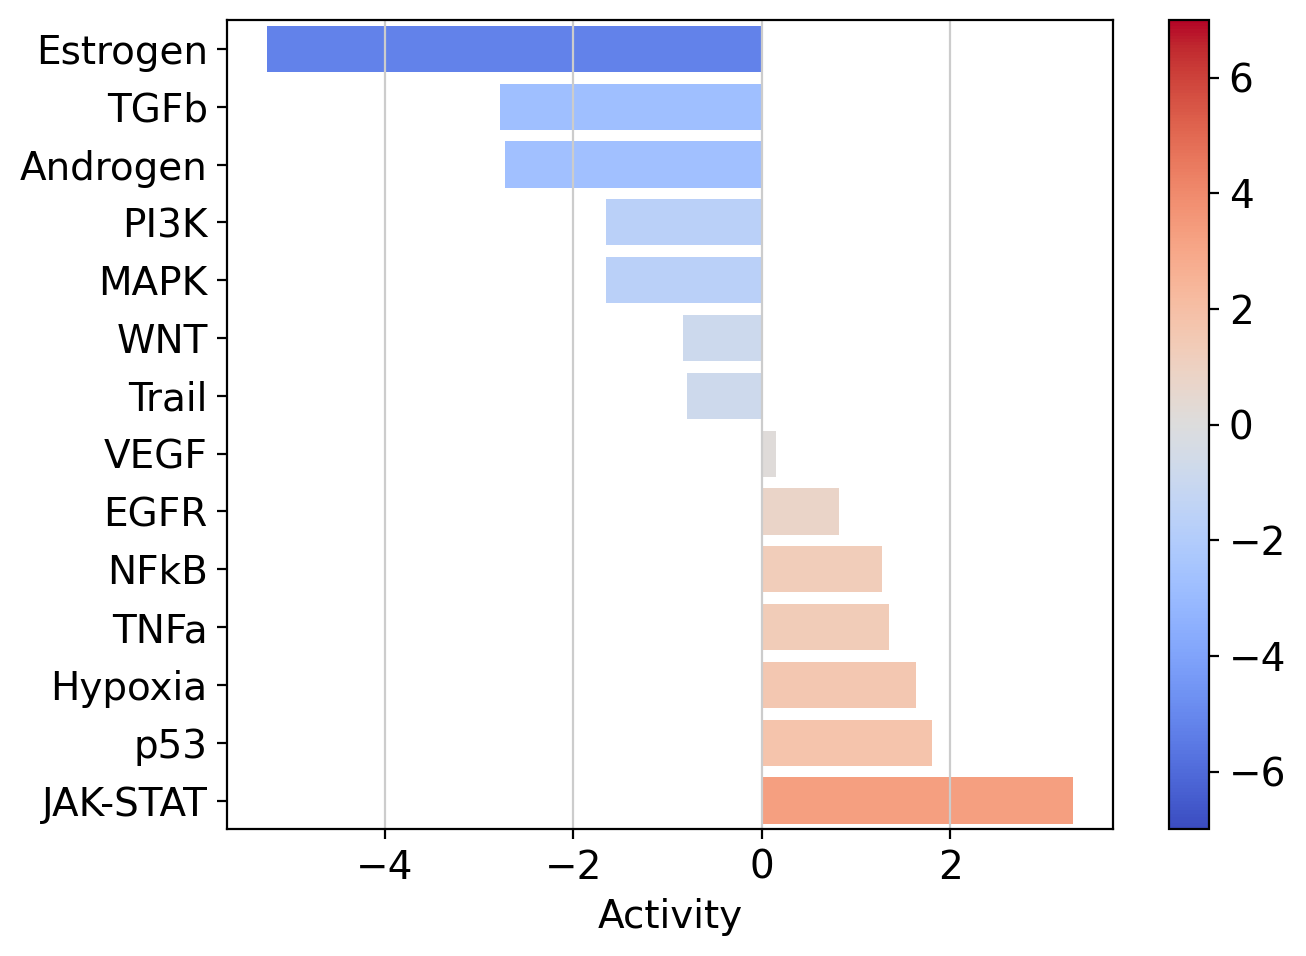

Factor 2


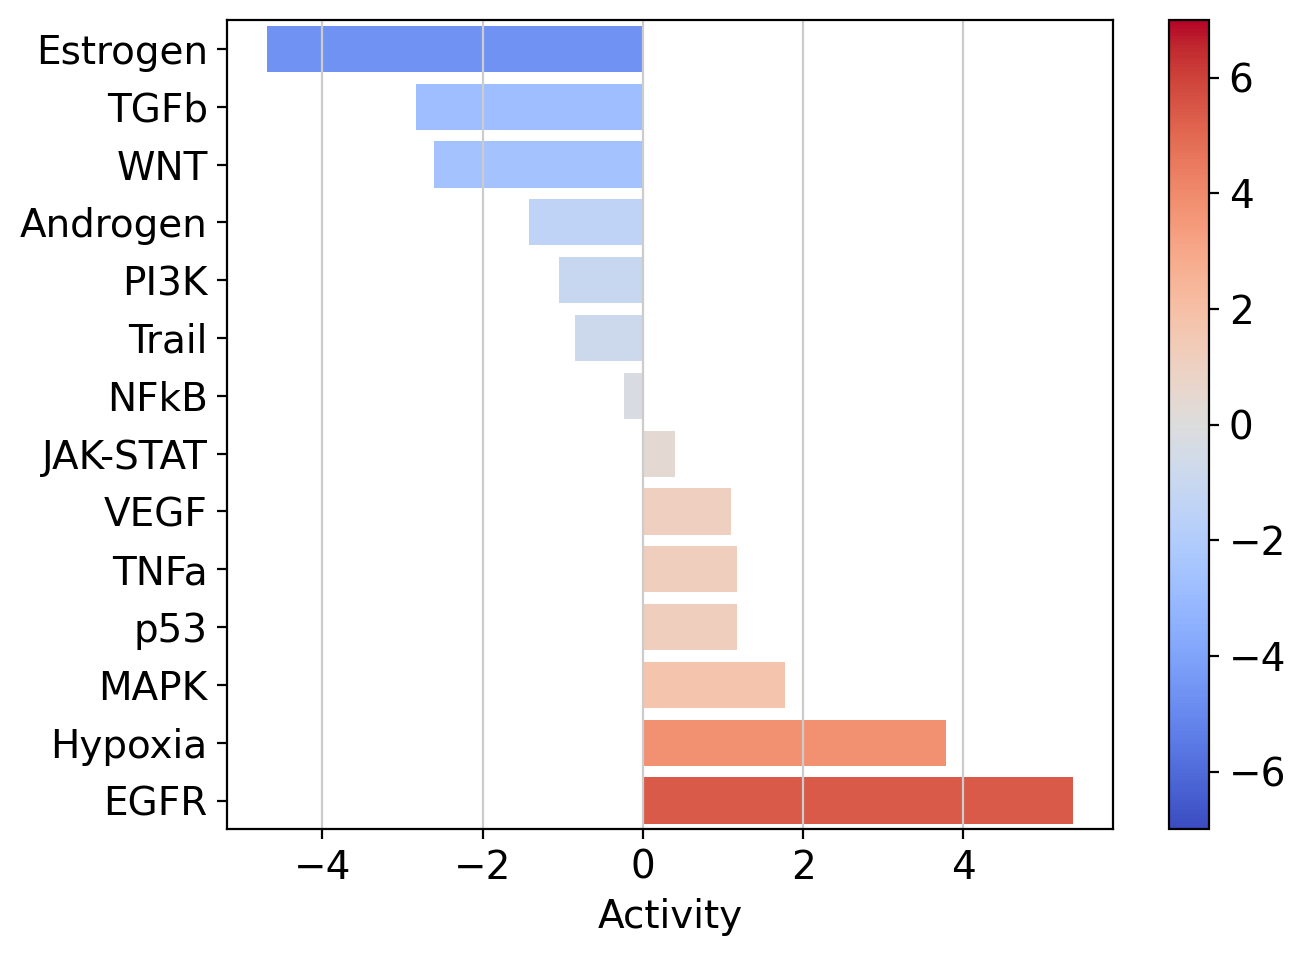

Factor 3


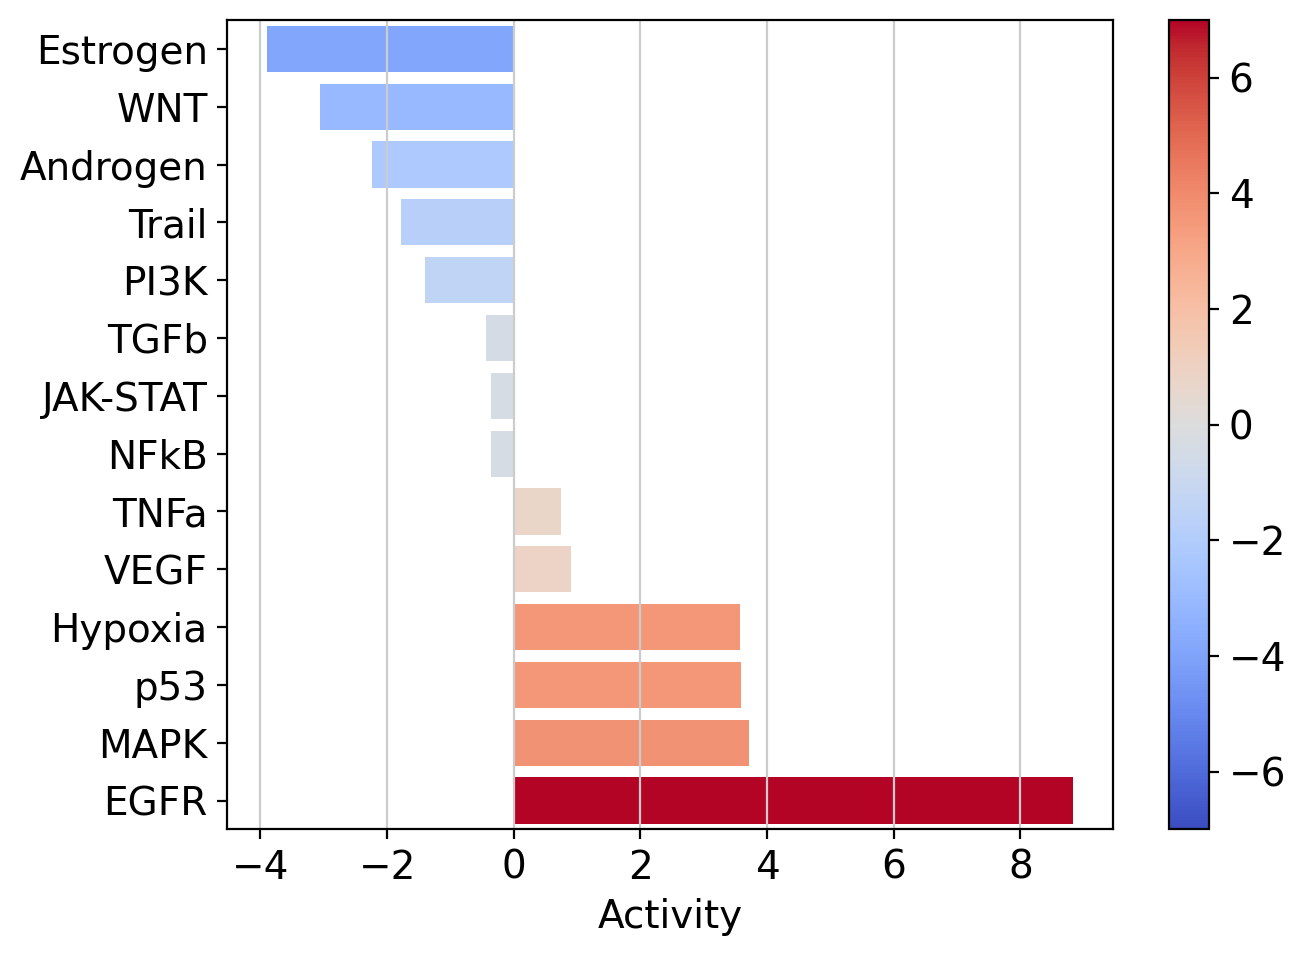

Factor 4


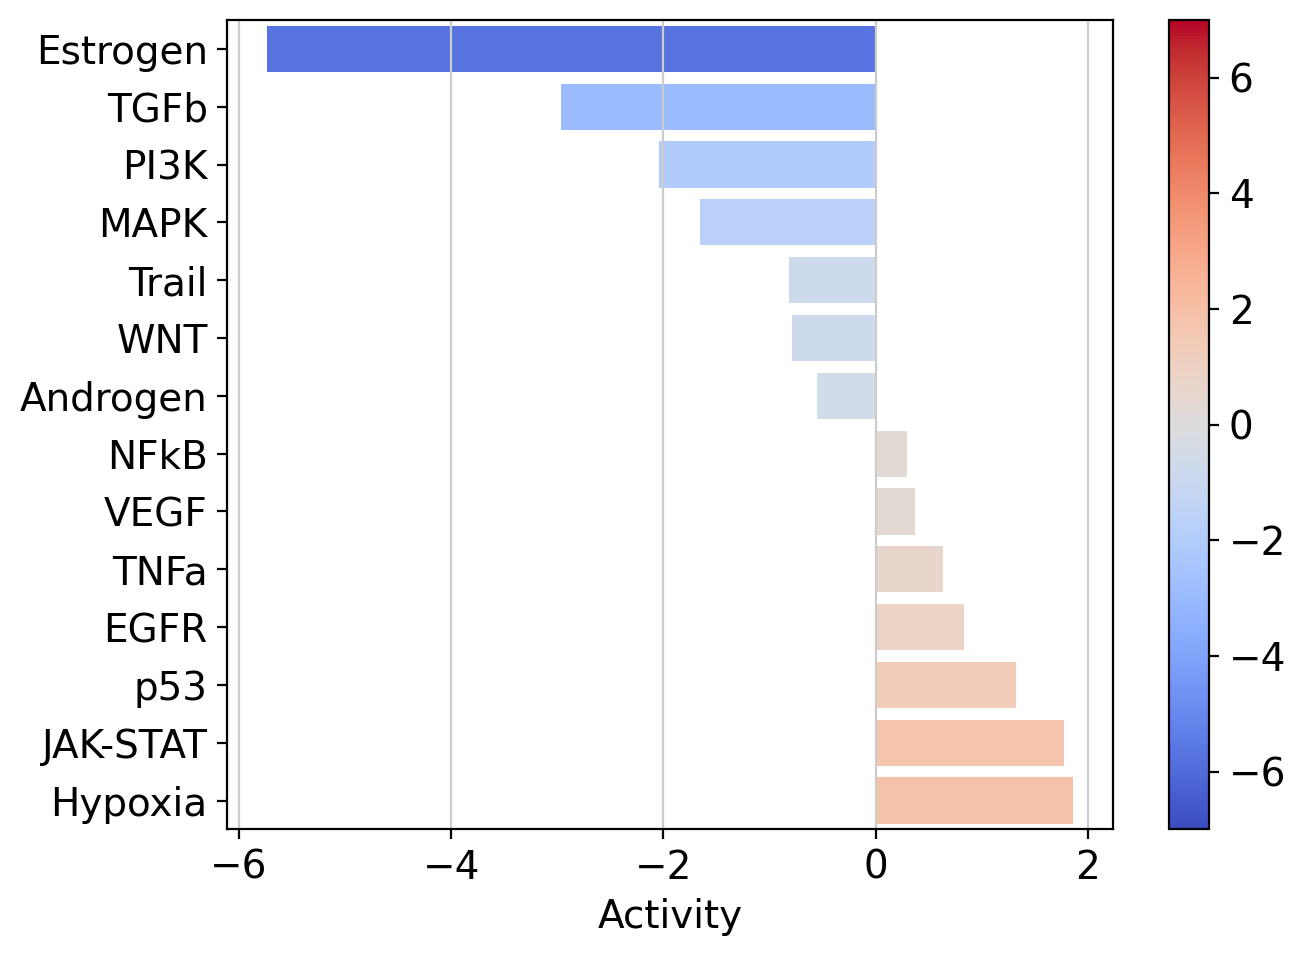

Factor 5


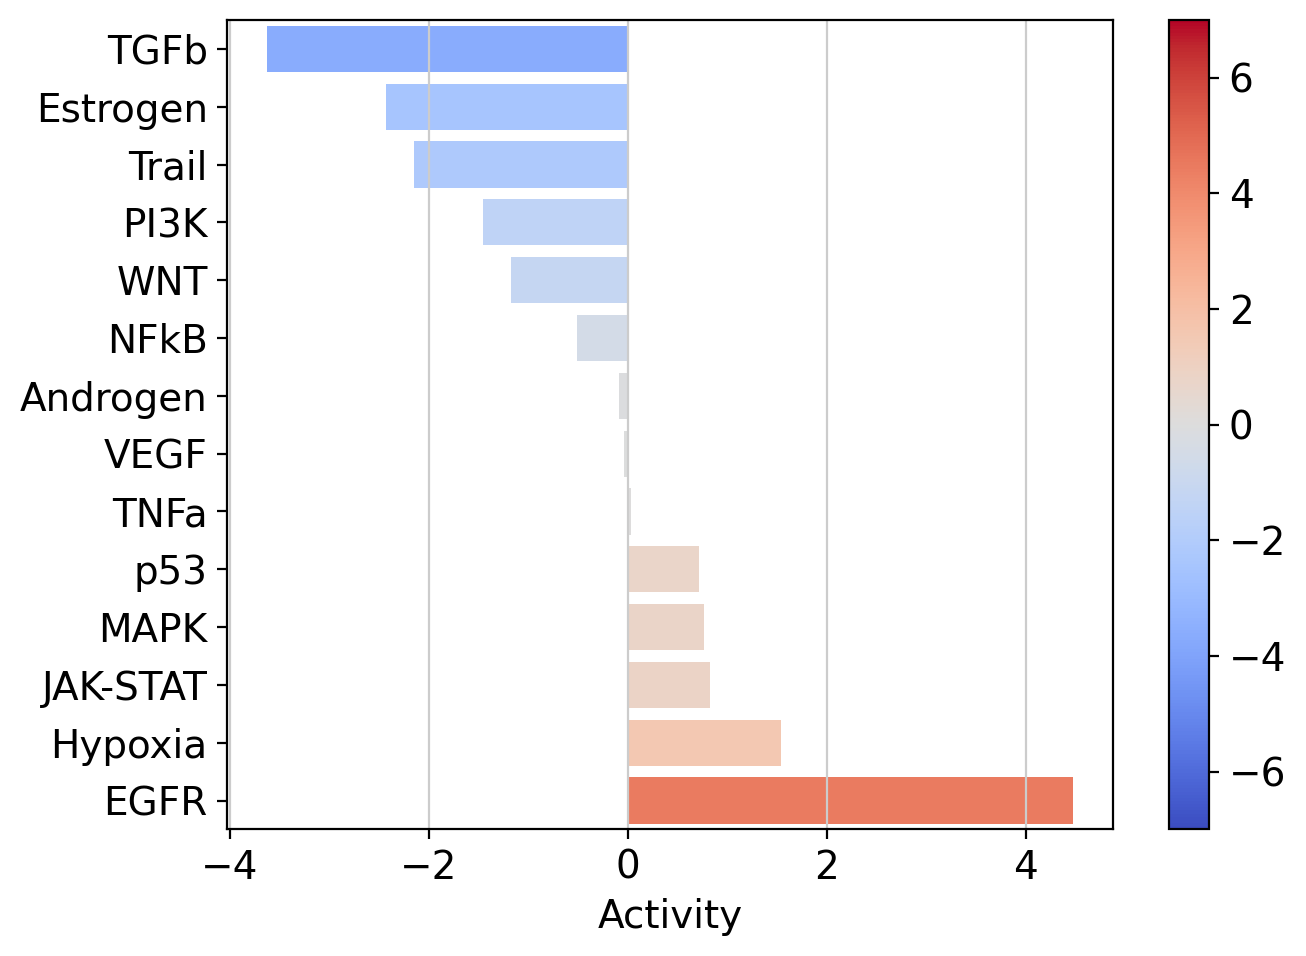

Factor 6


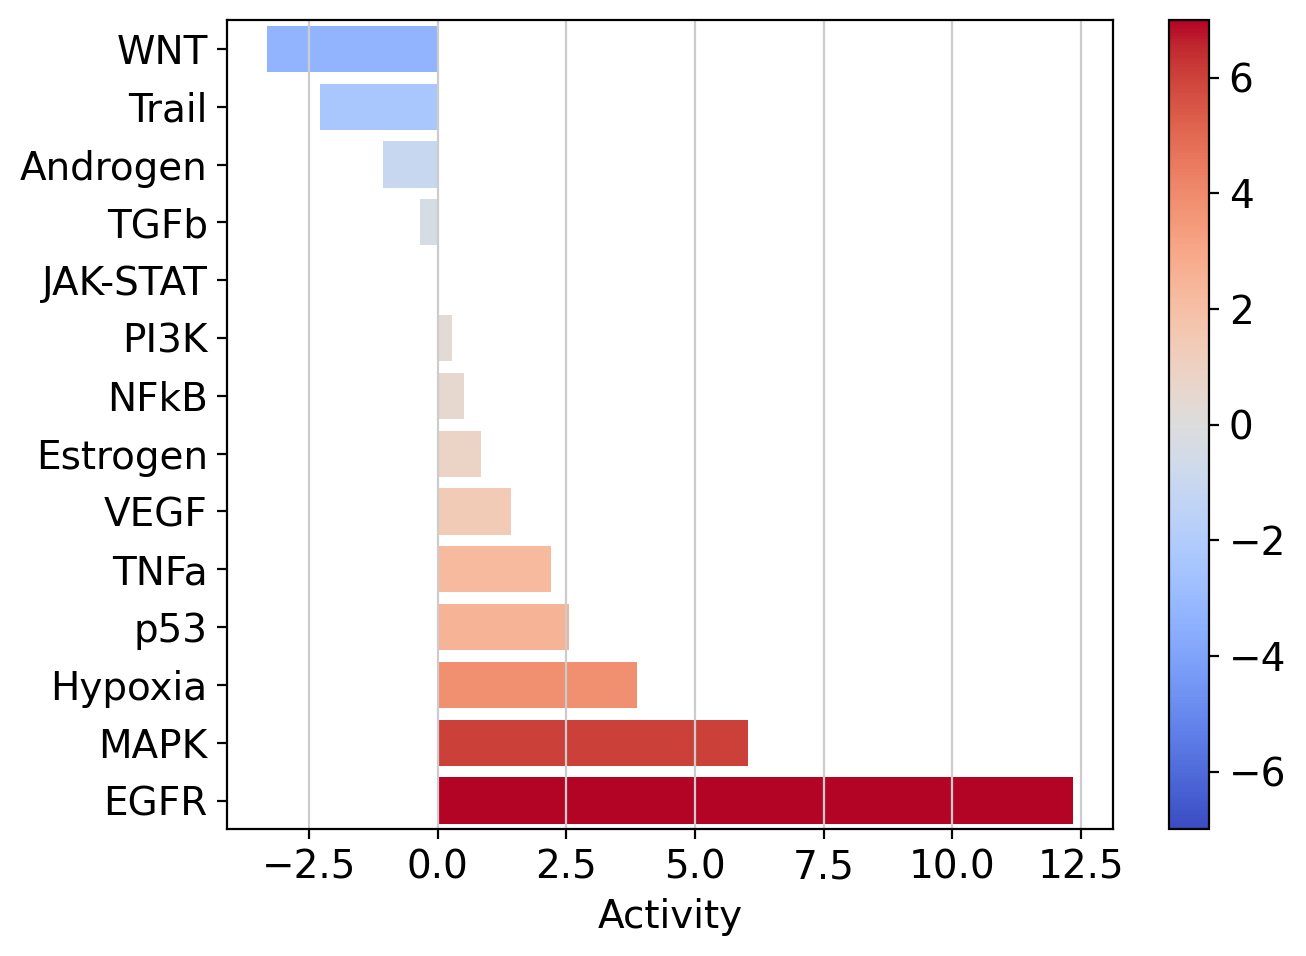

Factor 7


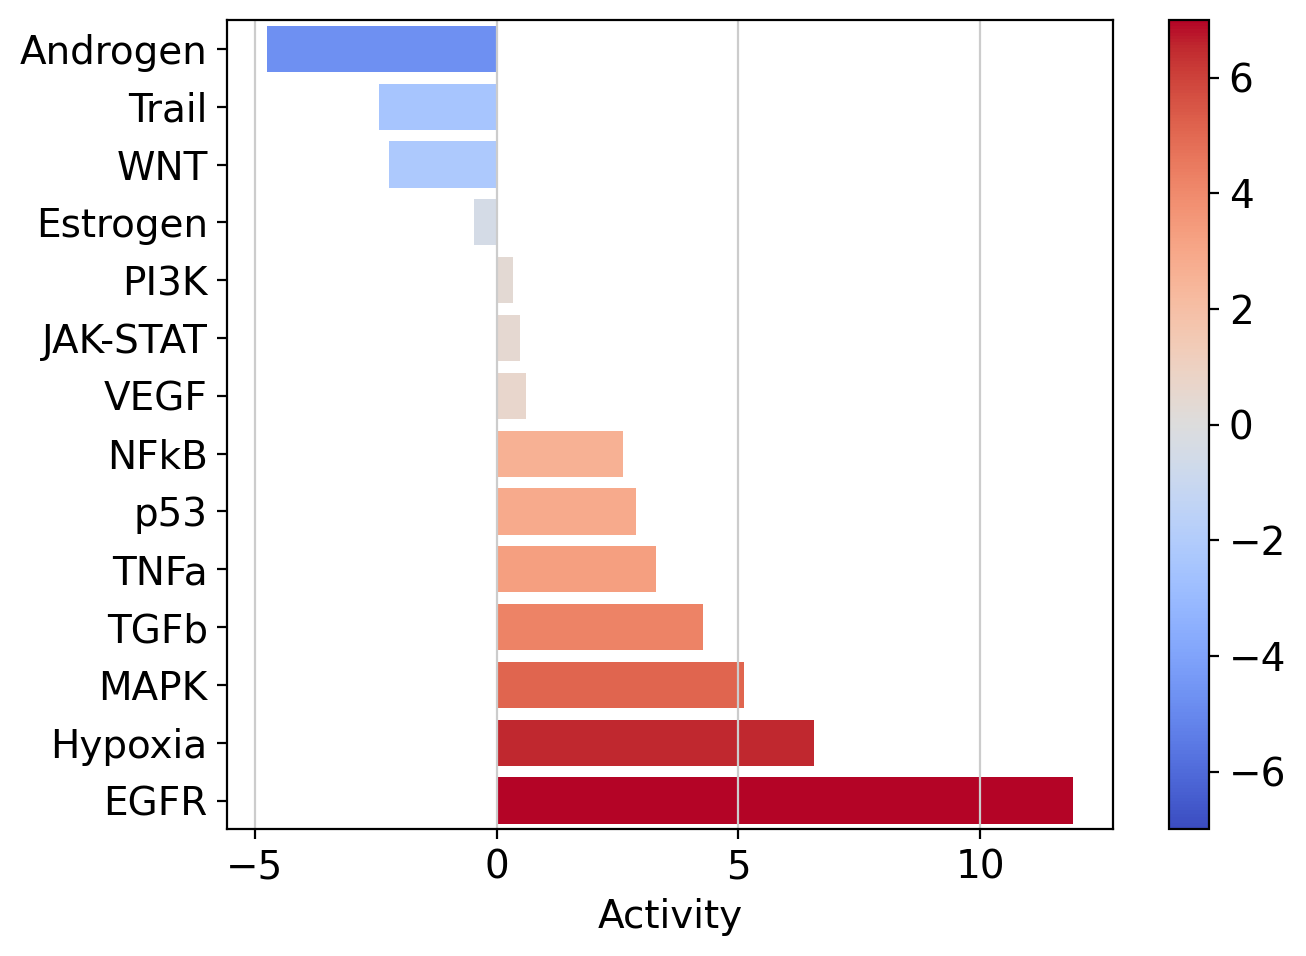

COPD


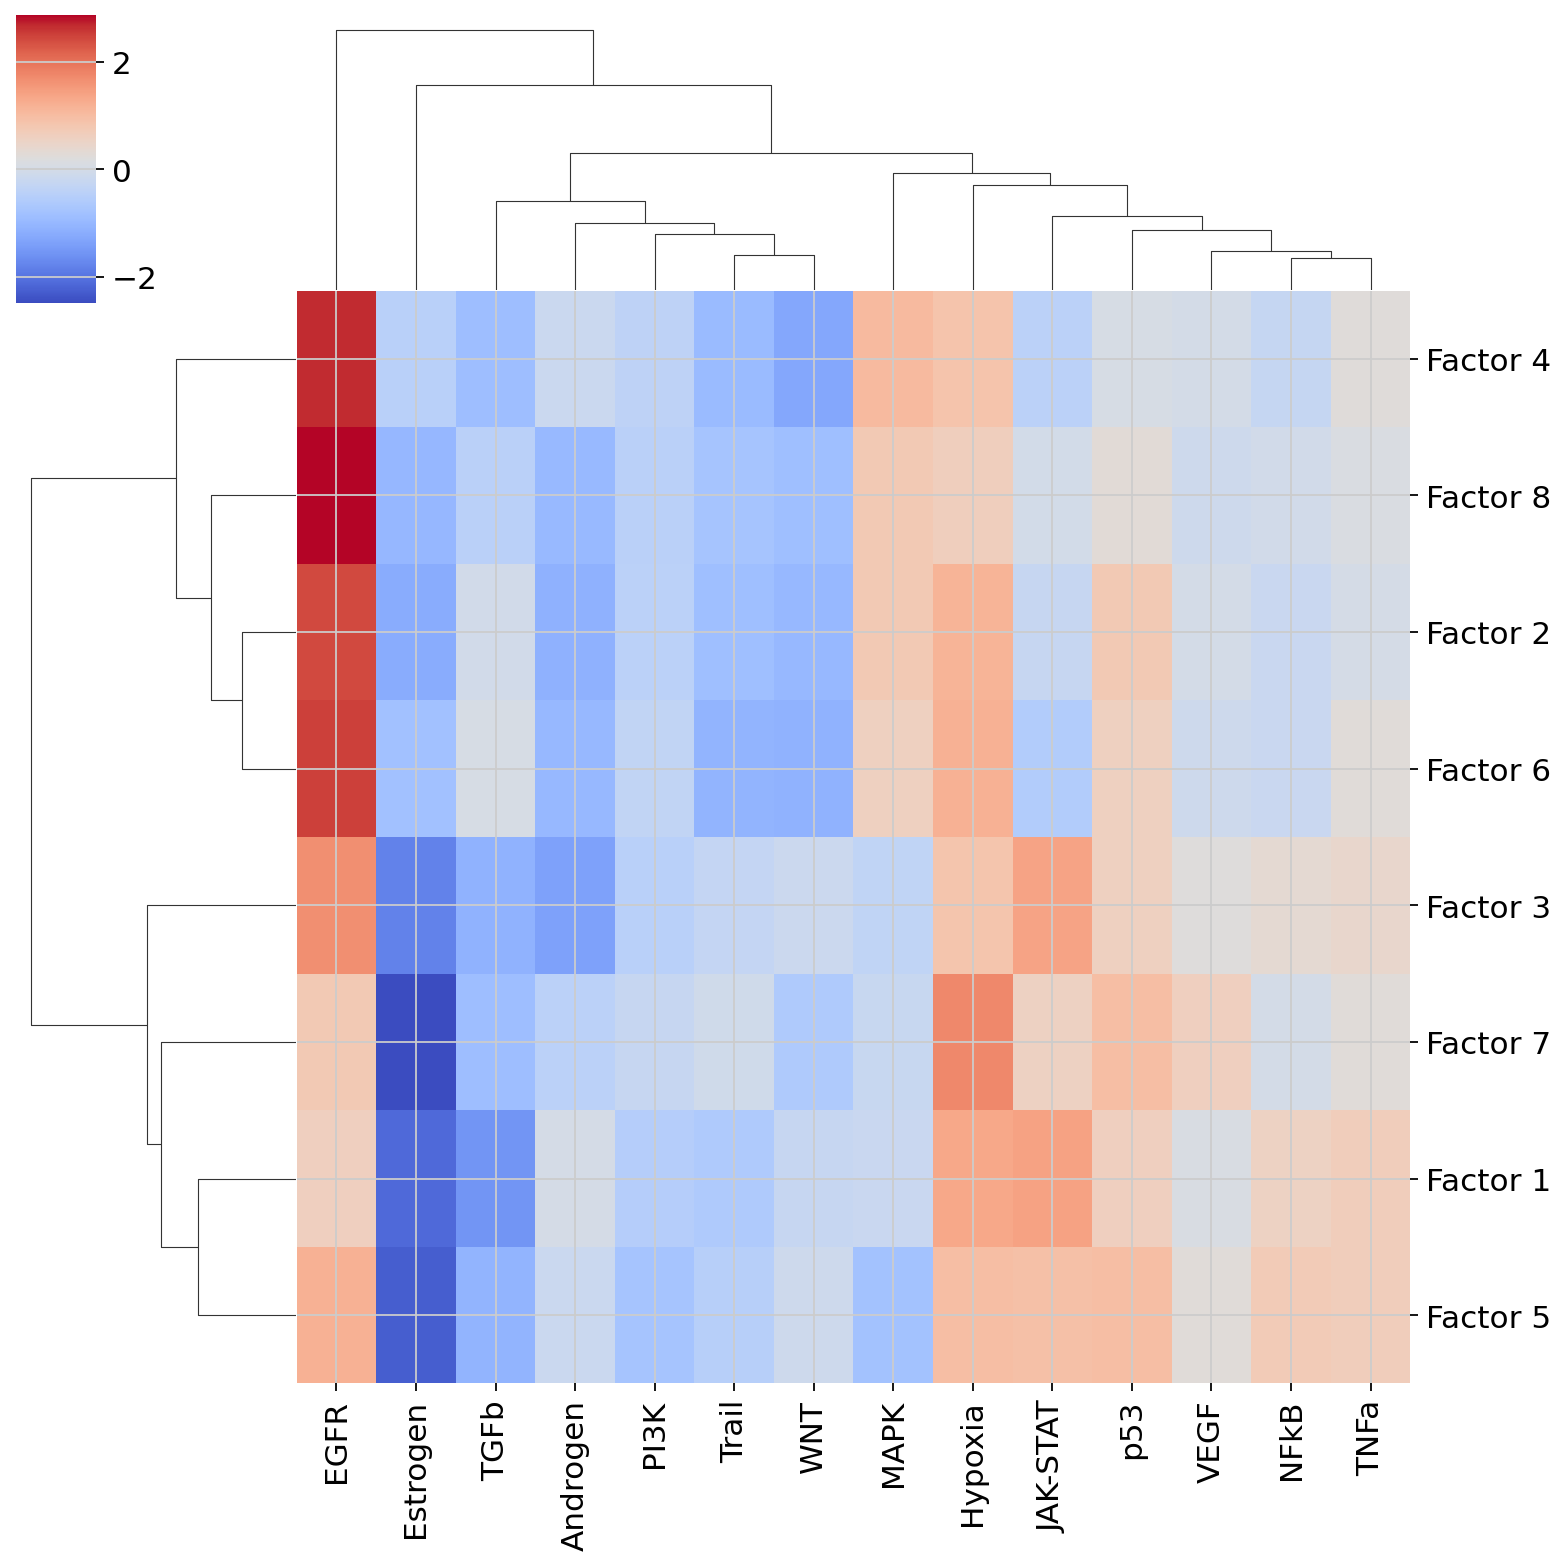

Factor 1


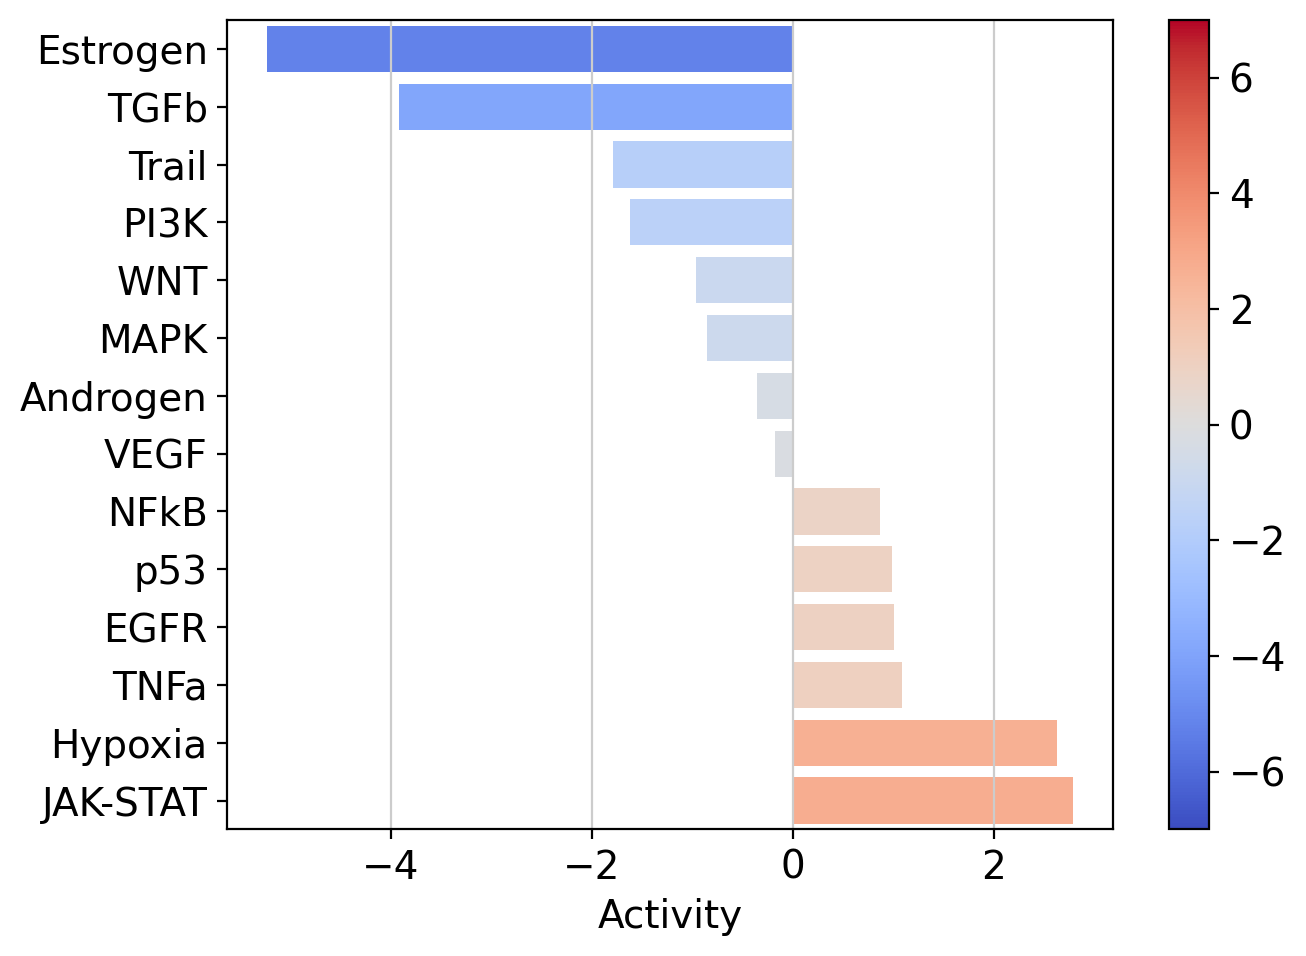

Factor 2


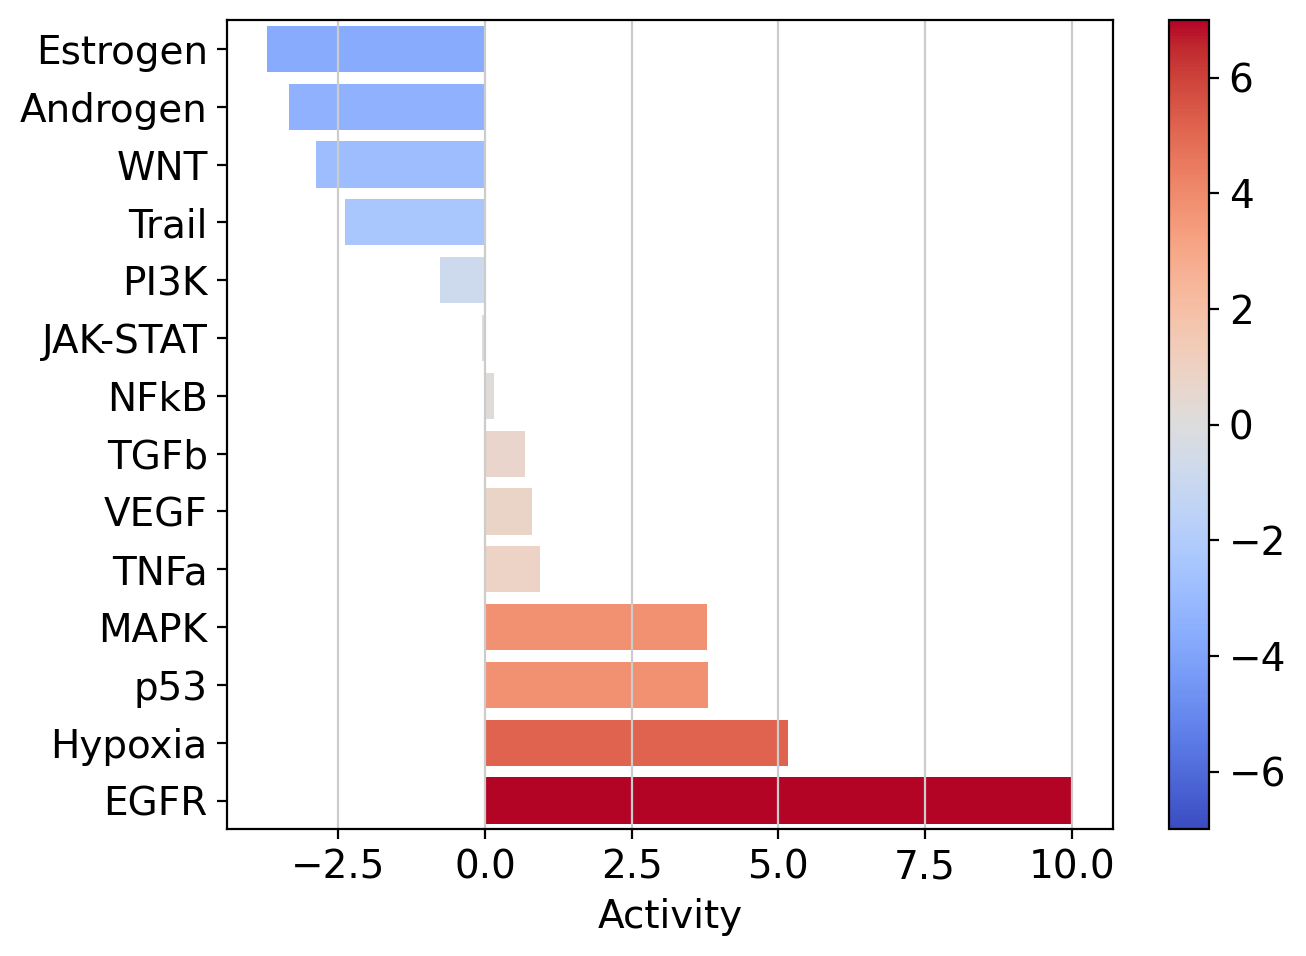

Factor 3


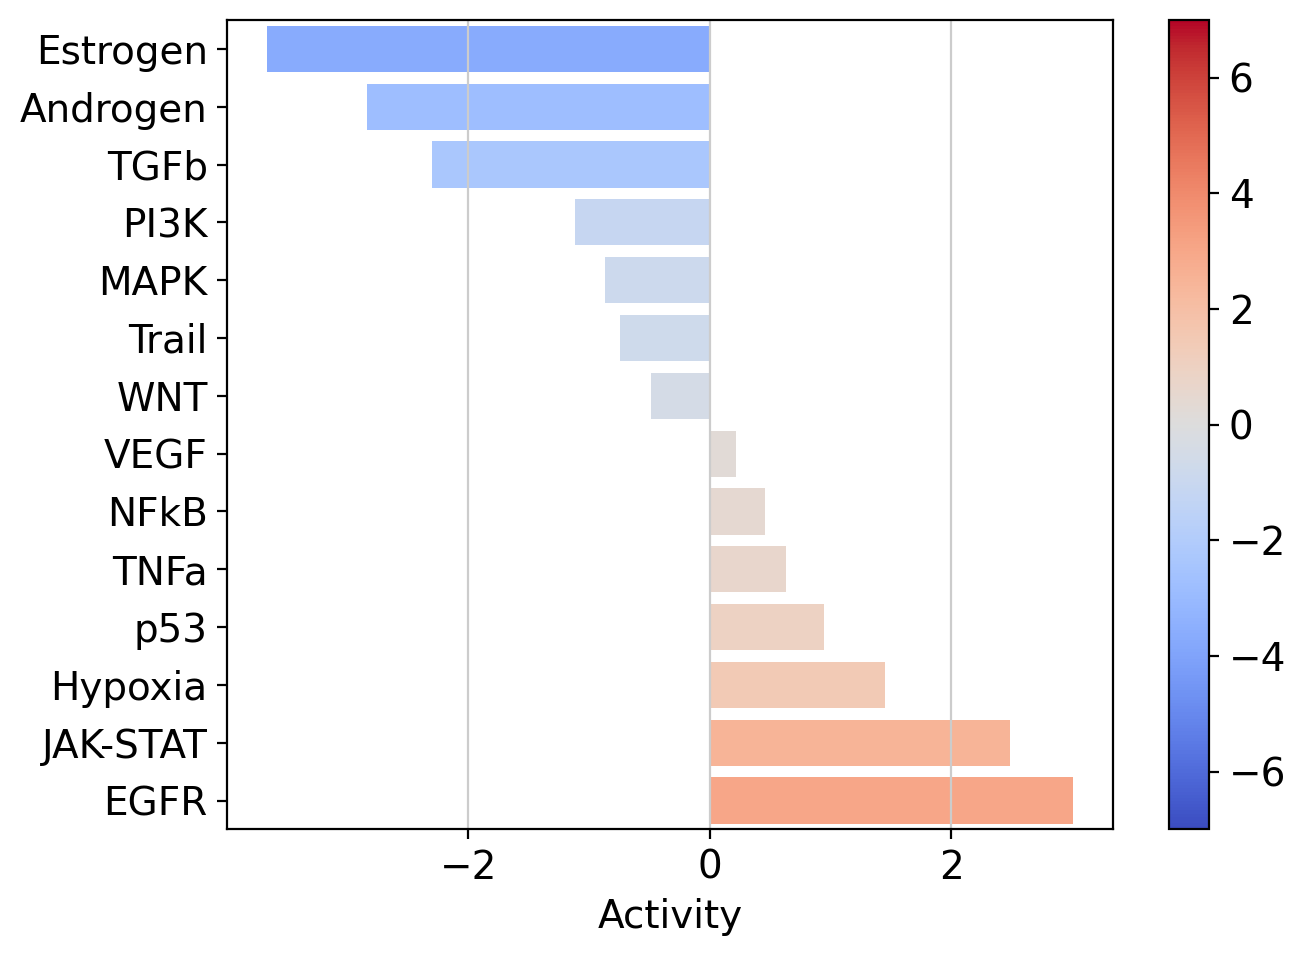

Factor 4


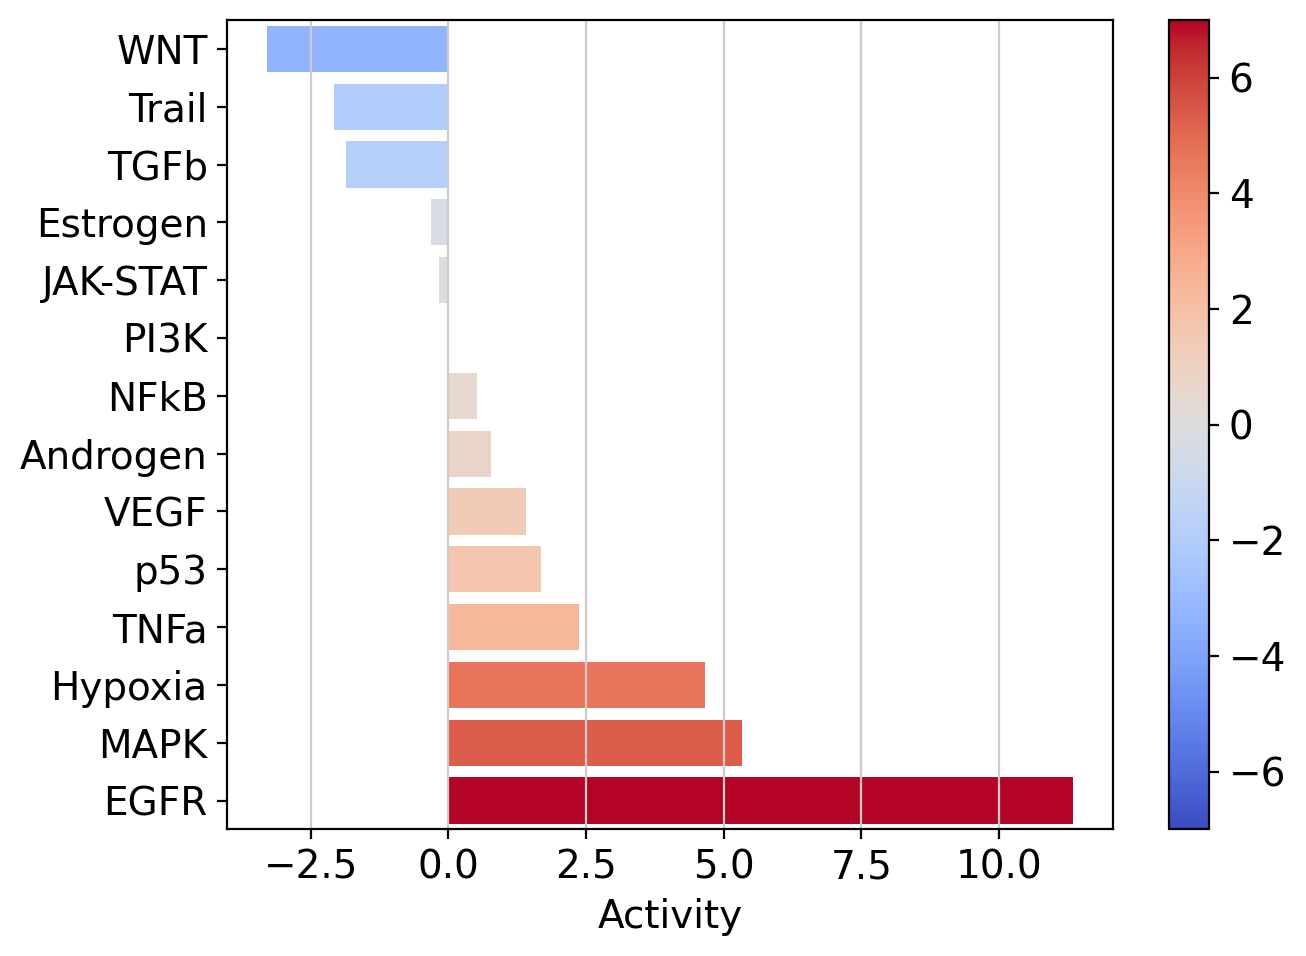

Factor 5


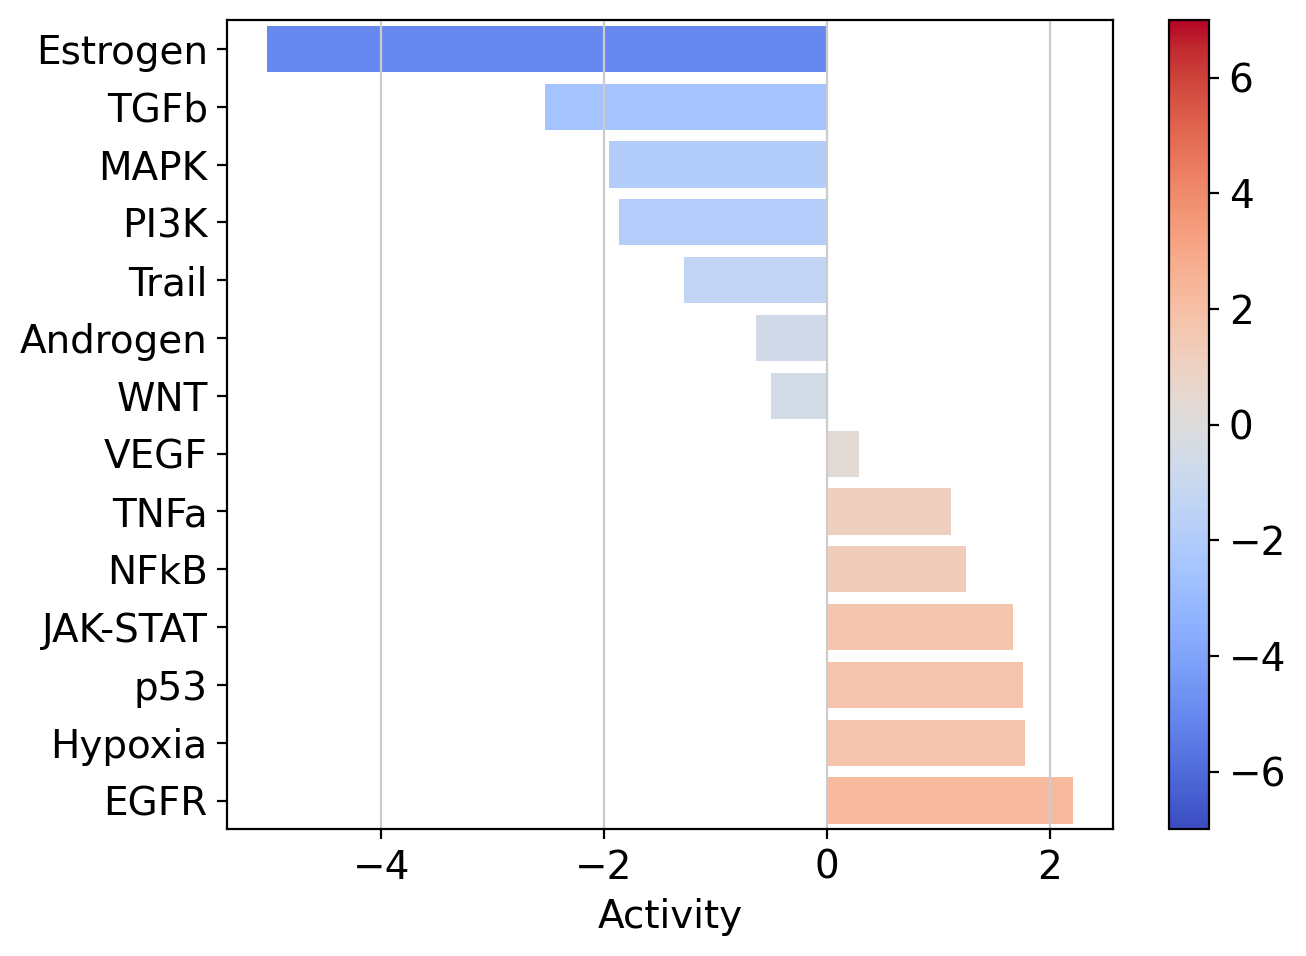

Factor 6


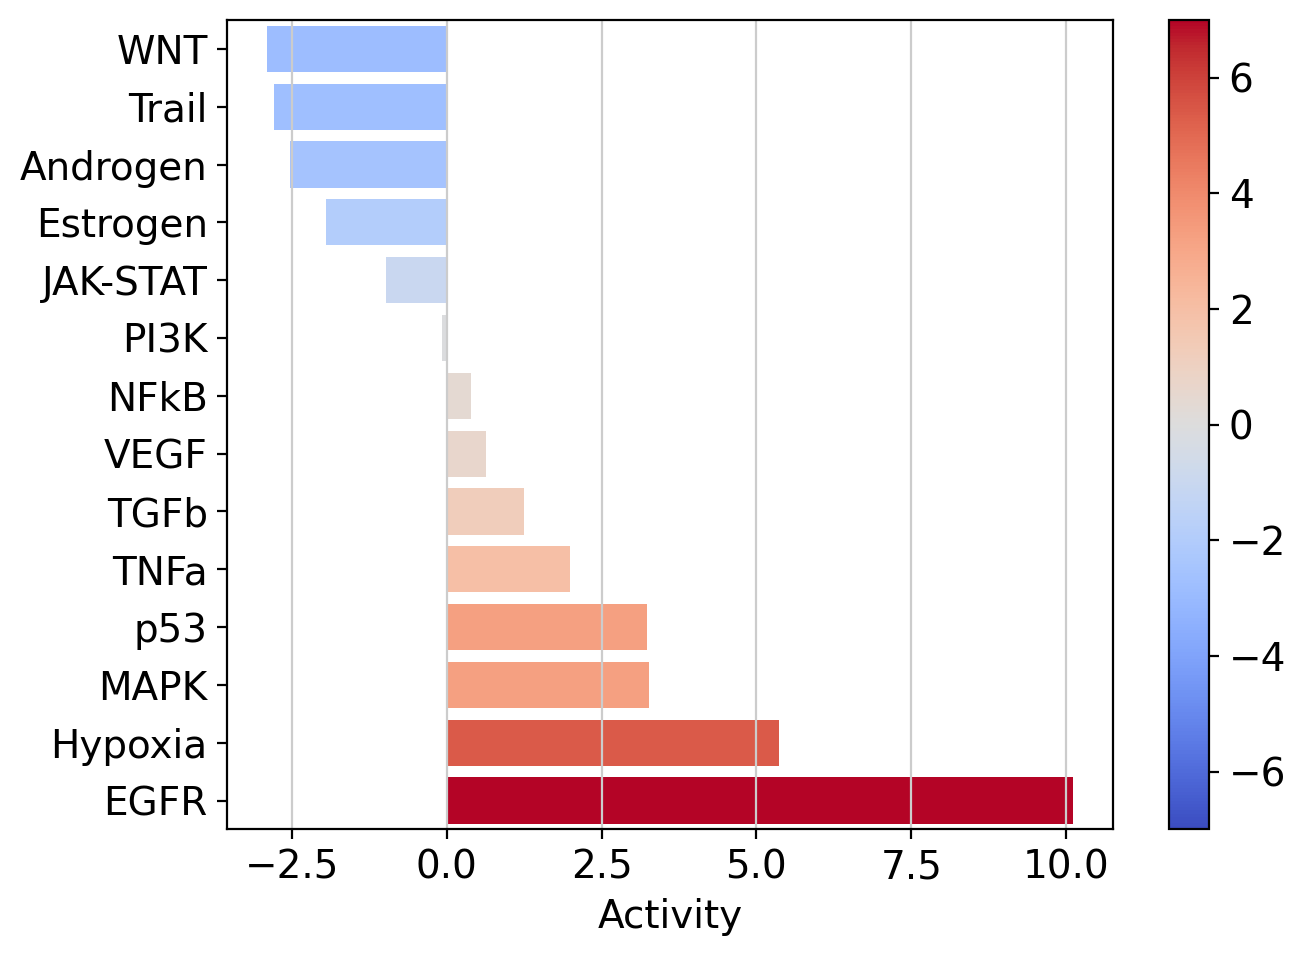

Factor 7


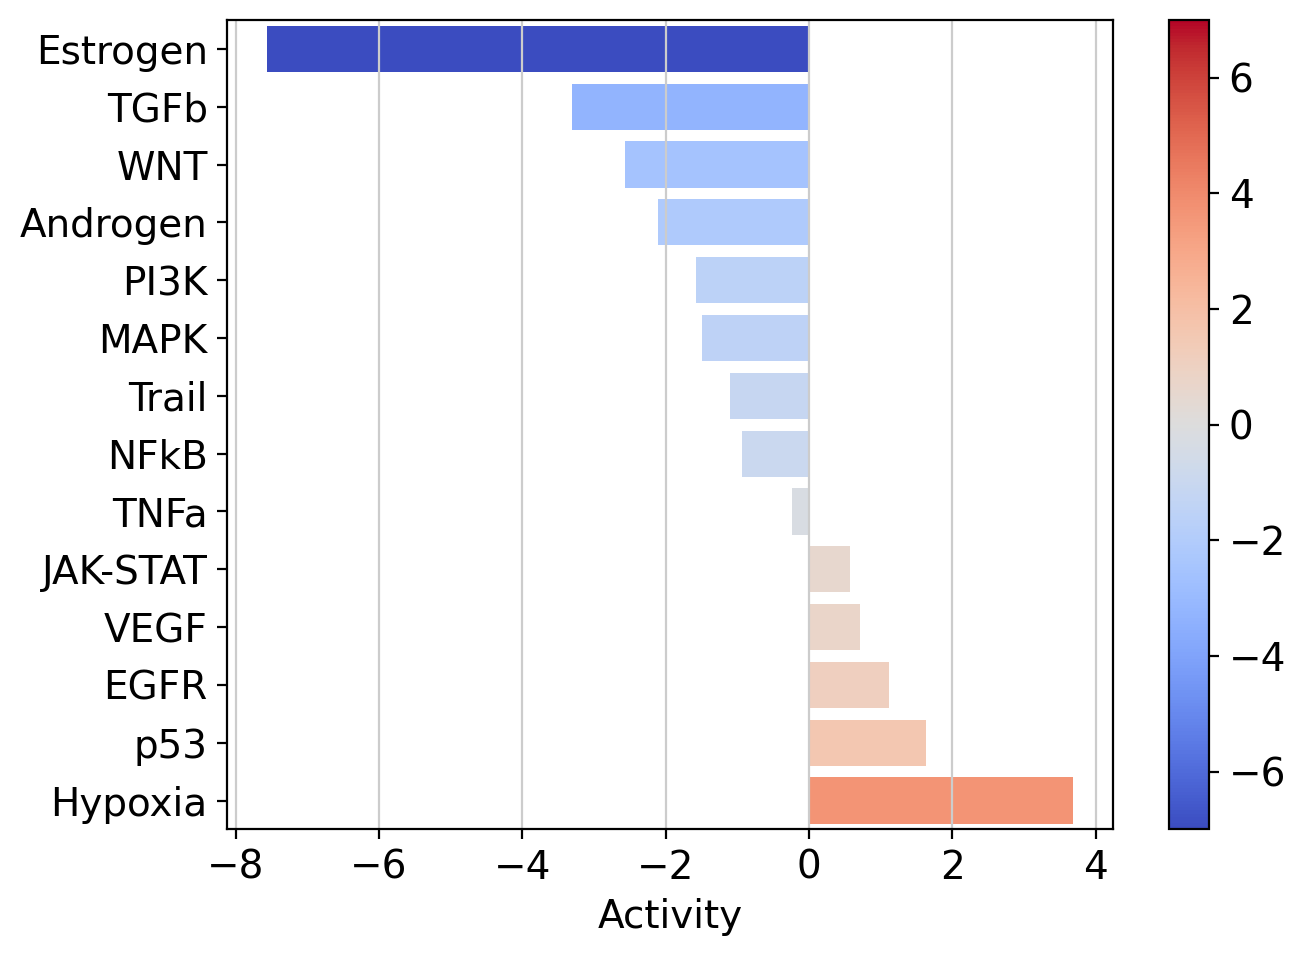

Factor 8


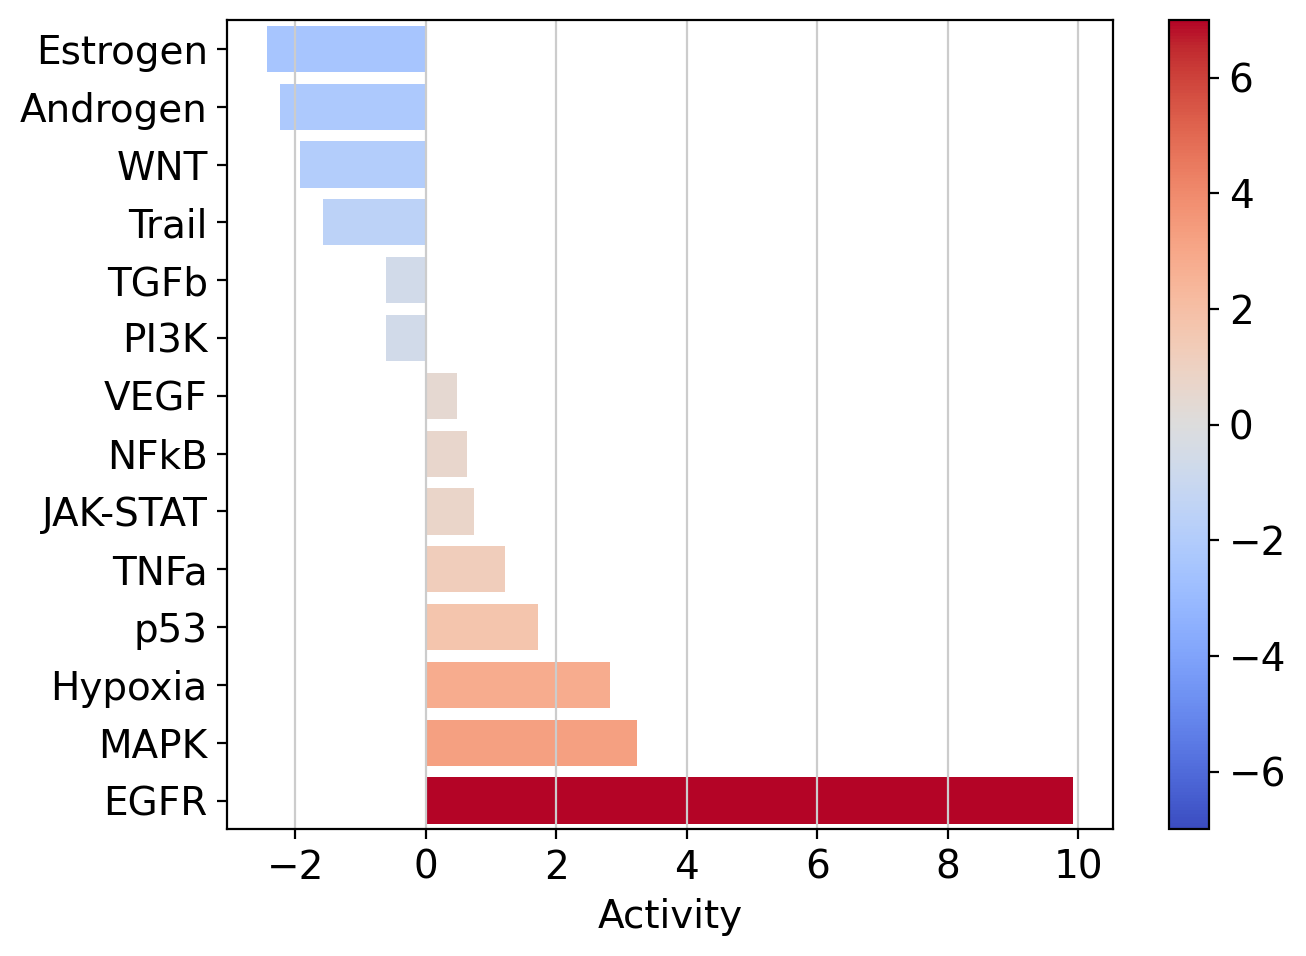

In [83]:
'''
Loading PROGENy pathways and list of ligand receptor pairs
'''
net = dc.get_progeny(organism='human', top=5000)
lr_pairs = li.resource.select_resource('consensus')
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
for condition, tensor in tensor_dict.items():
    lr_loadings = tensor.factors['Ligand-Receptor Pairs']
    estimate, pvals = dc.run_ulm(
        lr_loadings.transpose(),
        lr_progeny,
        source='source',
        target='interaction',
        use_raw=False,
    )
    factors = list(tensor.factors['Contexts'].columns)
    n_factors = len(factors)
    sns.clustermap(
        estimate, 
        xticklabels=estimate.columns, 
        cmap='coolwarm', 
        z_score=4
    )
    output_dir = figures_dir / 'loadings_clustermap'
    output_dir.mkdir(exist_ok=True)
    plt.savefig(output_dir / f'loadings_clustermap_{condition}.svg')
    print(condition)
    plt.show()
    for i, factor in enumerate(factors):
        dc.plot_barplot(
            estimate, 
            factor, 
            vertical=True, 
            cmap='coolwarm', 
            vmin=-7, 
            vmax=7, 
        )
        plt.tight_layout()
        output_dir = figures_dir / 'loadings_barplot'
        output_dir.mkdir(exist_ok=True)
        plt.savefig(output_dir / f'loadings_barplot_{condition}_{factor}.svg')
        print(factor)
        plt.show()

### GSEA enrichment

/mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/6-cell-cell_comms/4-tensor/.data/figures/GSEA already exists.


  0%|          | 0/7 [00:00<?, ?it/s]2024-09-19 12:52:49,872 [WARNING] Duplicated values found in preranked stats: 2.11% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 34 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'Y', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't']
Glyph IDs:   [0, 1, 2, 3, 36, 37, 38, 39, 40, 42, 44, 47, 49, 50, 51, 53, 54, 55, 56, 60, 68, 70, 71, 72, 75, 76, 78, 79, 80, 81, 82, 85, 86, 87]
Closed glyph list over 'GSUB': 34 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'Y', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'l', 'm', 'n', 'nonmarkingretur

Healthy


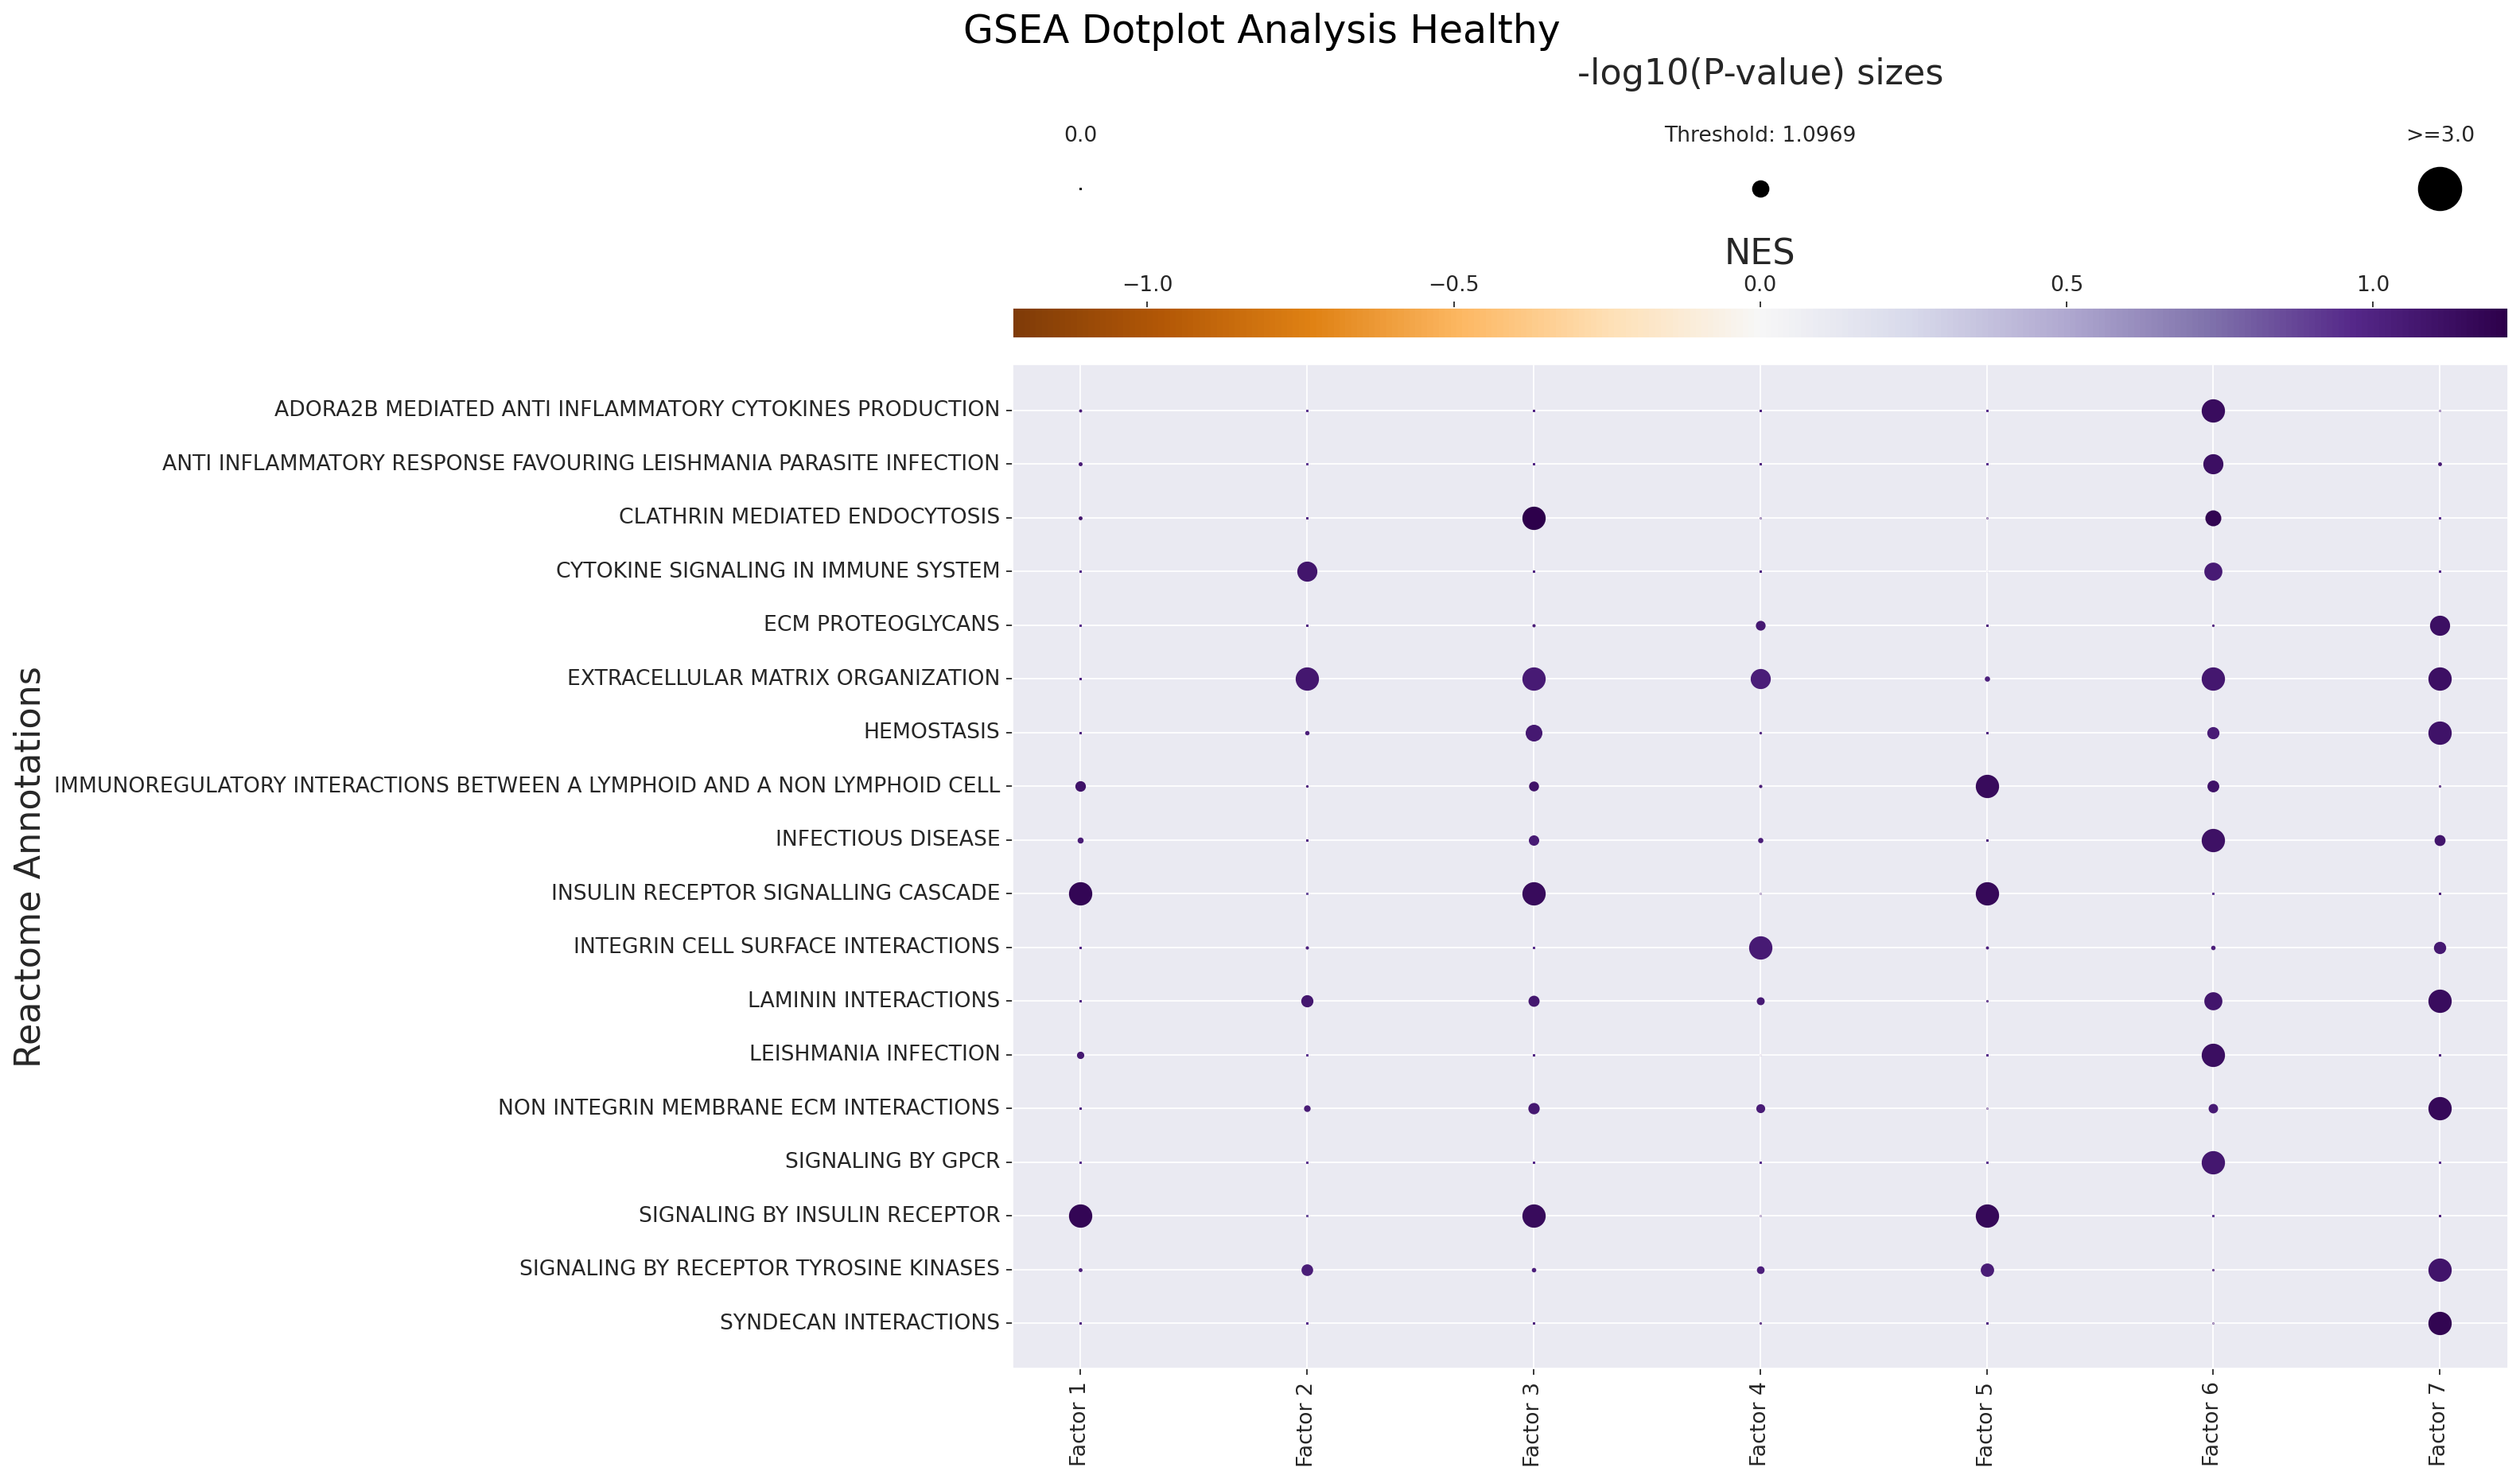

/mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/6-cell-cell_comms/4-tensor/.data/figures/GSEA already exists.


  0%|          | 0/8 [00:00<?, ?it/s]2024-09-19 12:53:03,400 [WARNING] Duplicated values found in preranked stats: 3.54% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 32 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't']
Glyph IDs:   [0, 1, 2, 3, 36, 37, 38, 39, 40, 42, 44, 47, 49, 50, 51, 53, 54, 55, 68, 70, 71, 72, 75, 76, 78, 79, 80, 81, 82, 85, 86, 87]
Closed glyph list over 'GSUB': 32 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'I', 'L', 'N', 'O', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'h', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 

COPD


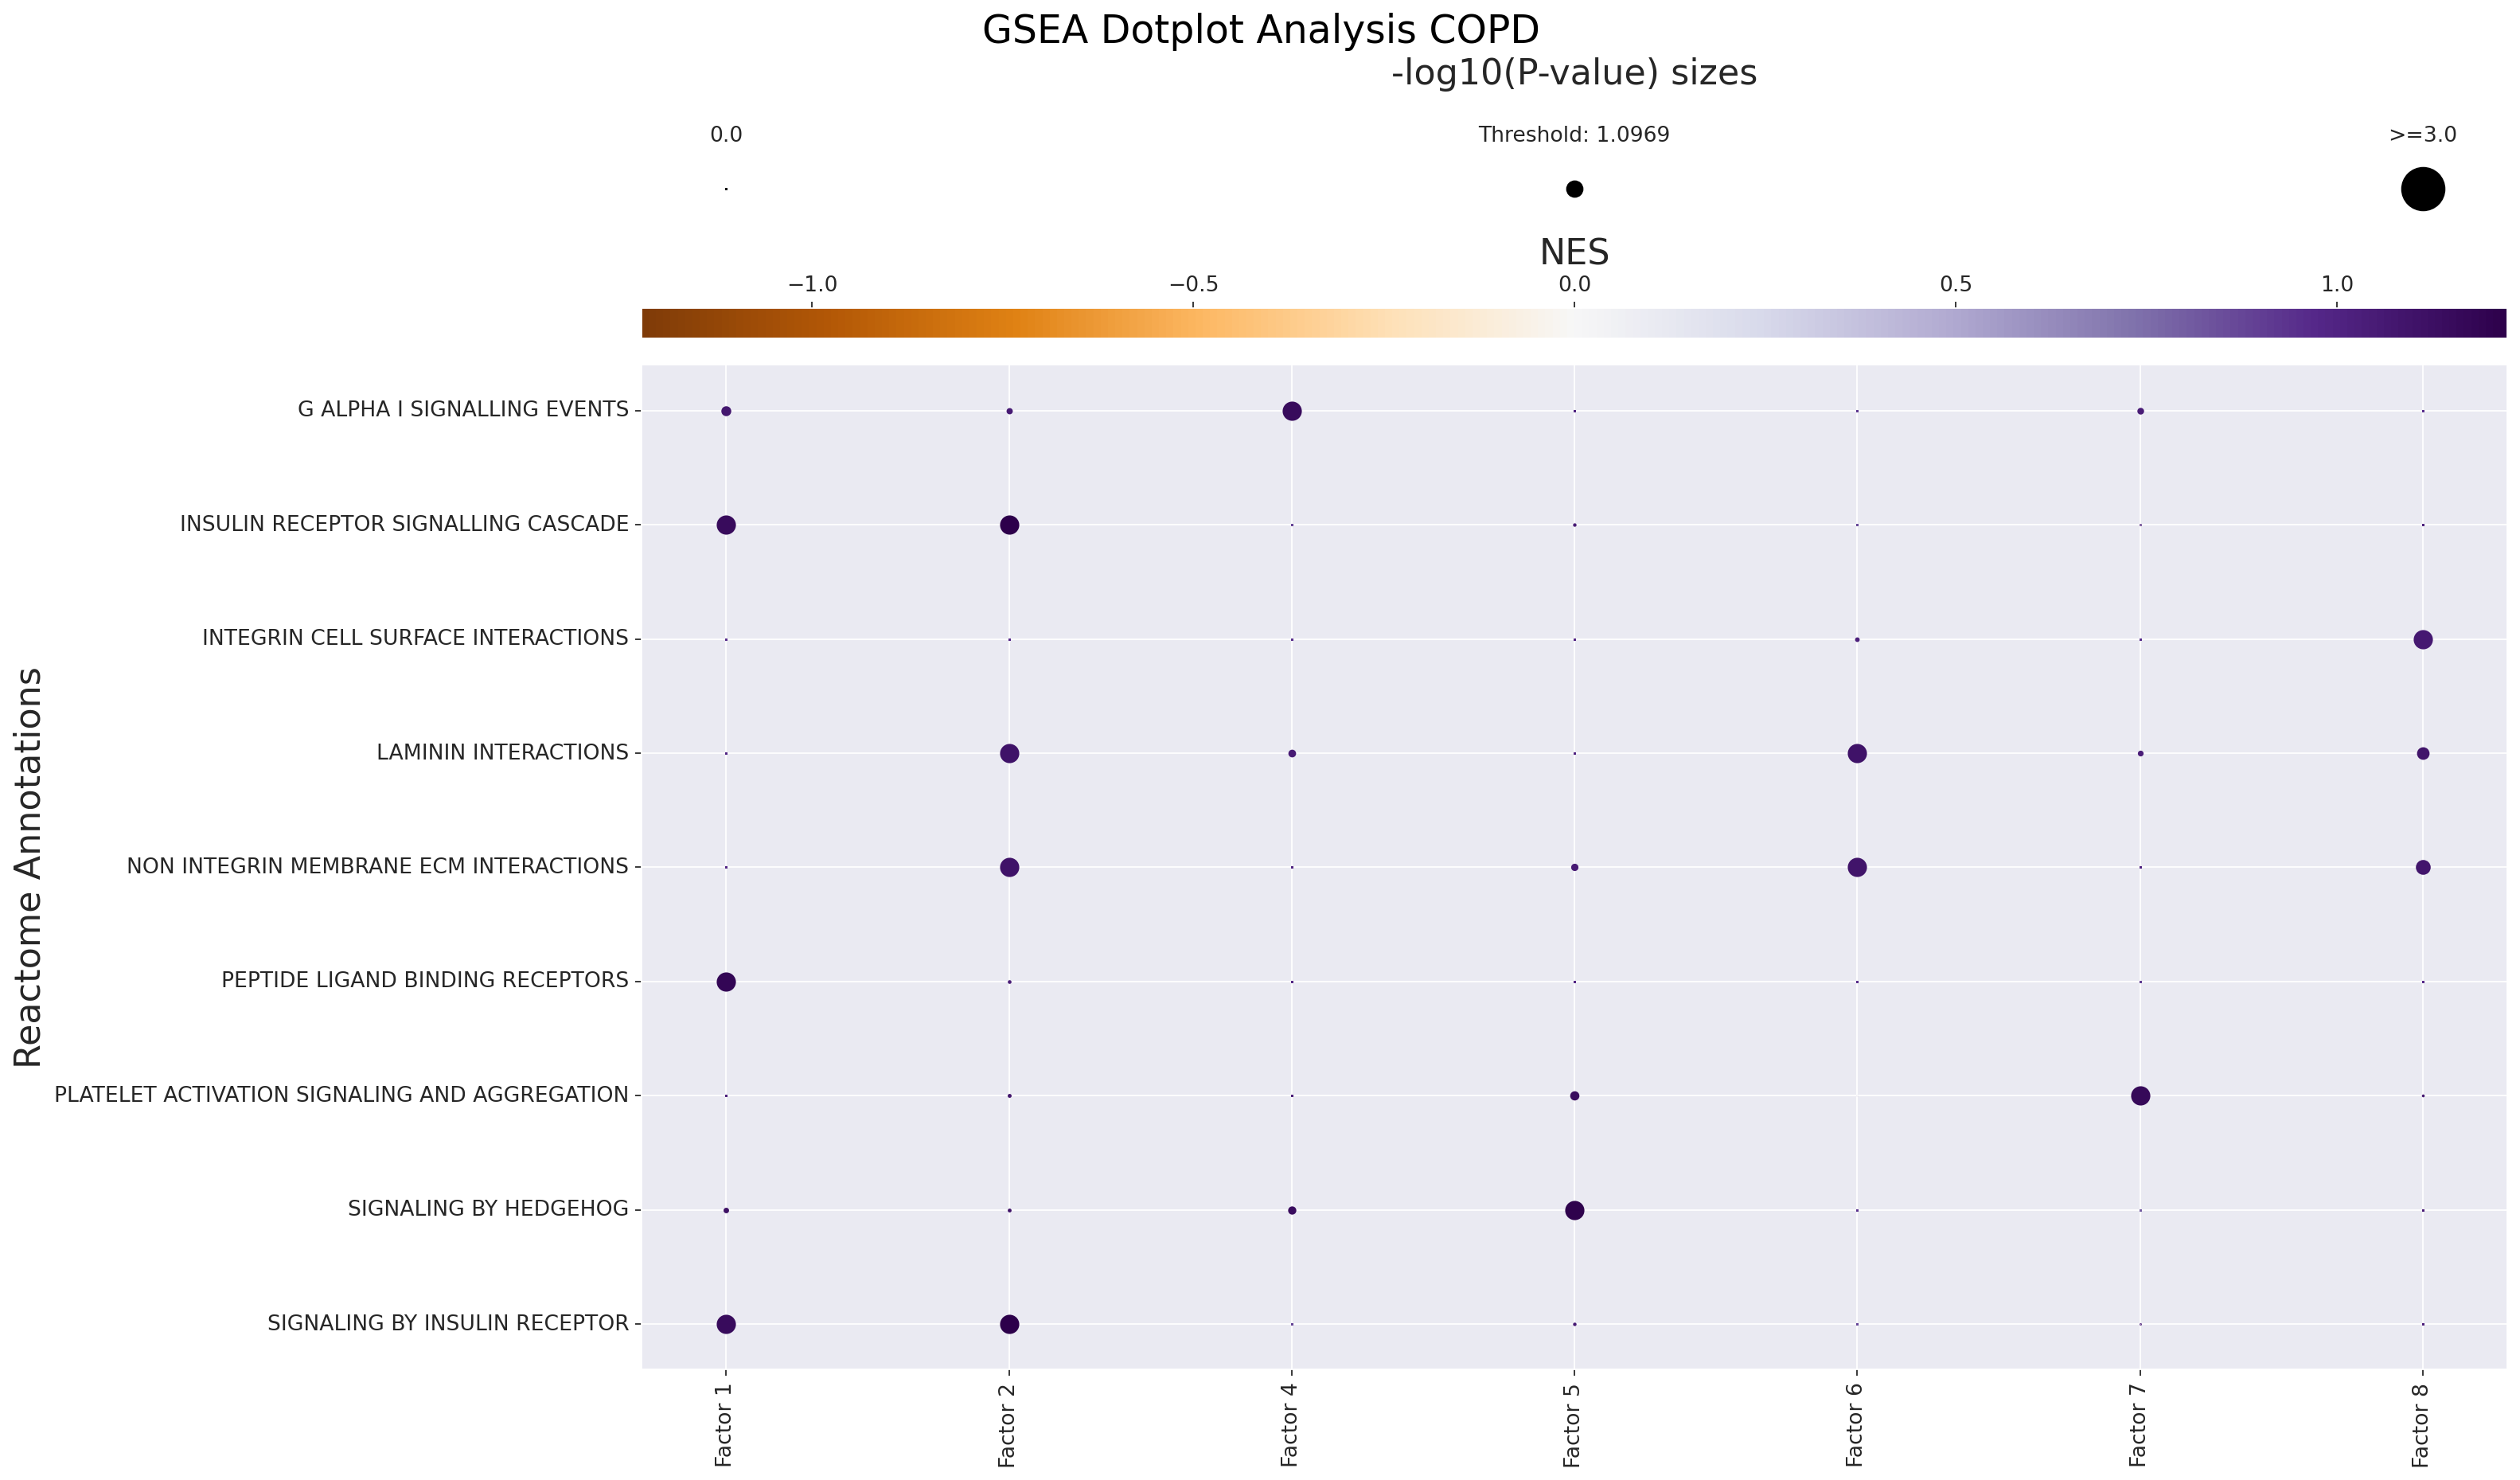

In [ ]:
for condition, tensor in tensor_dict.items():
    GSEA_enrichment_analysis(
        tensor=tensor_dict[condition],
        condition=condition,
        figures_dir=figures_dir
    )

In [93]:
figures_dir / 'factor_pathway_loadings'

PosixPath('/mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/6-cell-cell_comms/4-tensor/.data/figures/factor_pathway_loadings')

In [92]:
output_dir

PosixPath('/mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/6-cell-cell_comms/4-tensor/.data/figures/loadings_barplot')

### Factor Pathway Loadings

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/6-cell-cell_comms/4-tensor/.data/figures/factor_pathway_loadings/Healthy_Factor 4_EGFR_loadings.svg
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 15 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_label : Removed 72 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 15 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: Plot

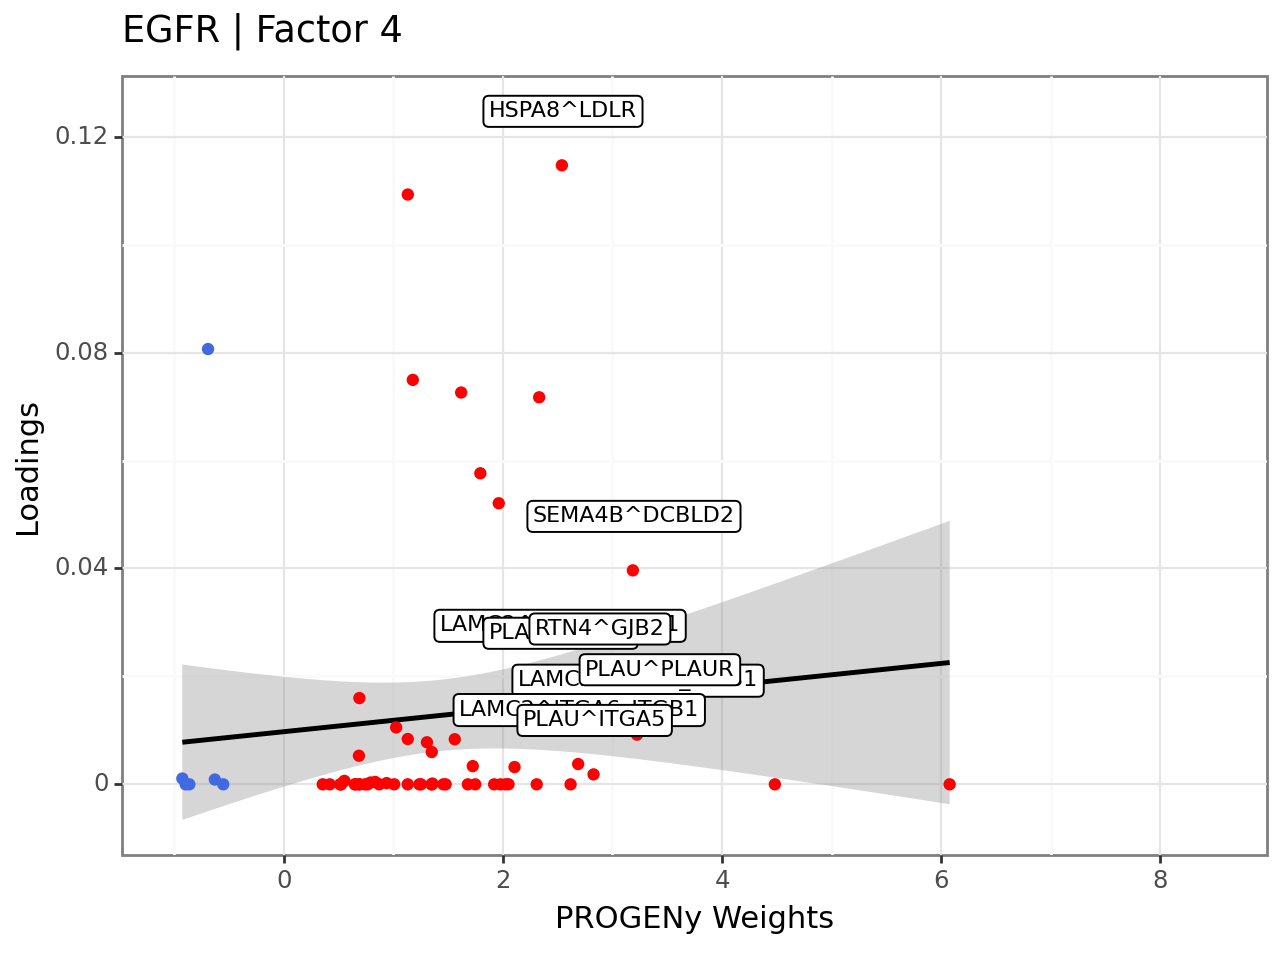

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/6-cell-cell_comms/4-tensor/.data/figures/factor_pathway_loadings/Healthy_Factor 4_Hypoxia_loadings.svg
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 5 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_label : Removed 78 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 5 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: Plo

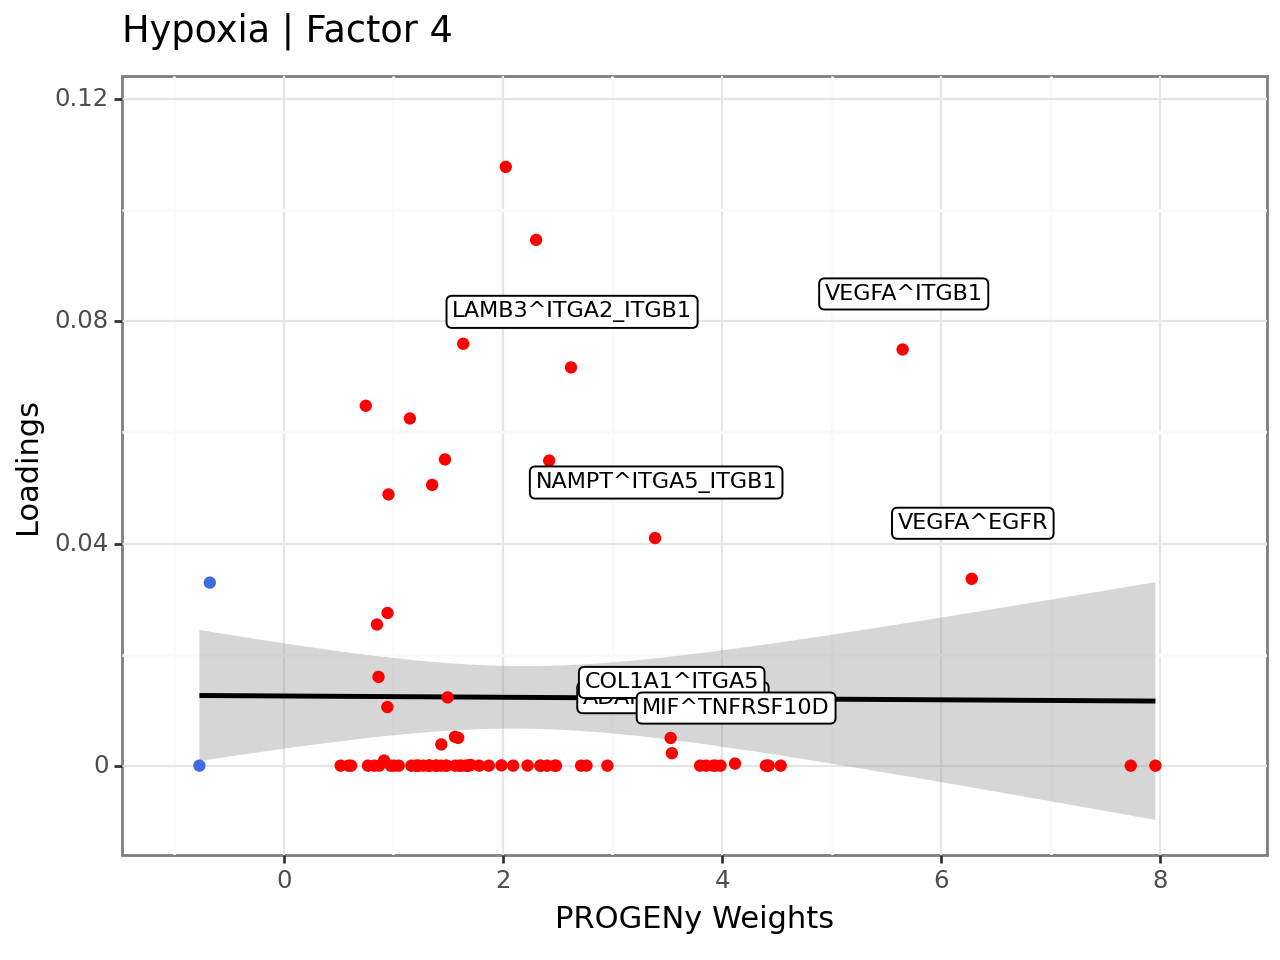

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/6-cell-cell_comms/4-tensor/.data/figures/factor_pathway_loadings/Healthy_Factor 4_JAK-STAT_loadings.svg


/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_label : Removed 69 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_label : Removed 69 rows containing missing values.


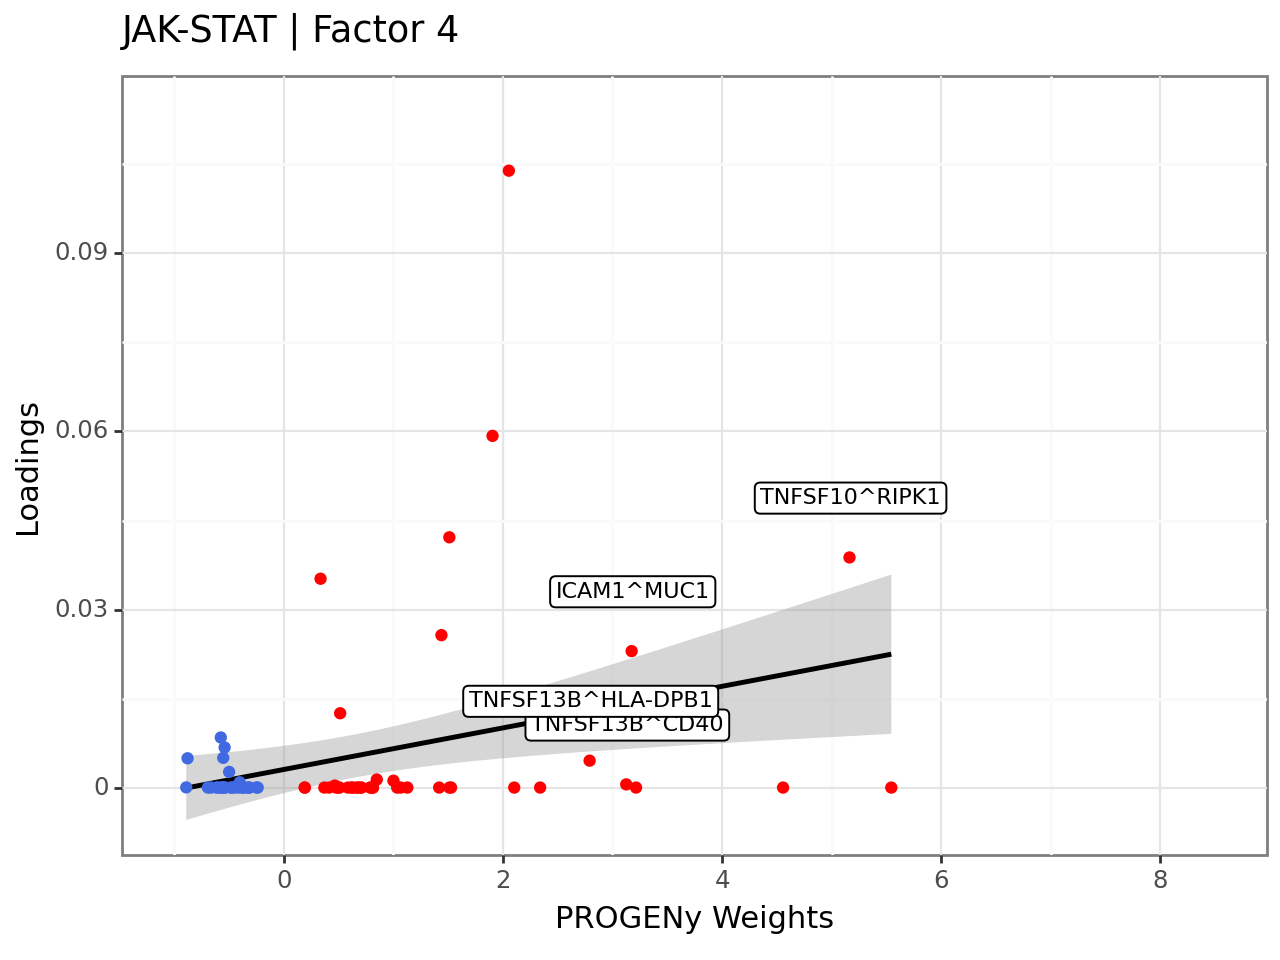

/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /mnt/LaCIE/ceger/Projects/COPD/COPD_influenza/6-cell-cell_comms/4-tensor/.data/figures/factor_pathway_loadings/Healthy_Factor 4_p53_loadings.svg


/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_label : Removed 26 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.
/home/ceger/miniforge3/envs/liana_c2c-env/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_label : Removed 26 rows containing missing values.


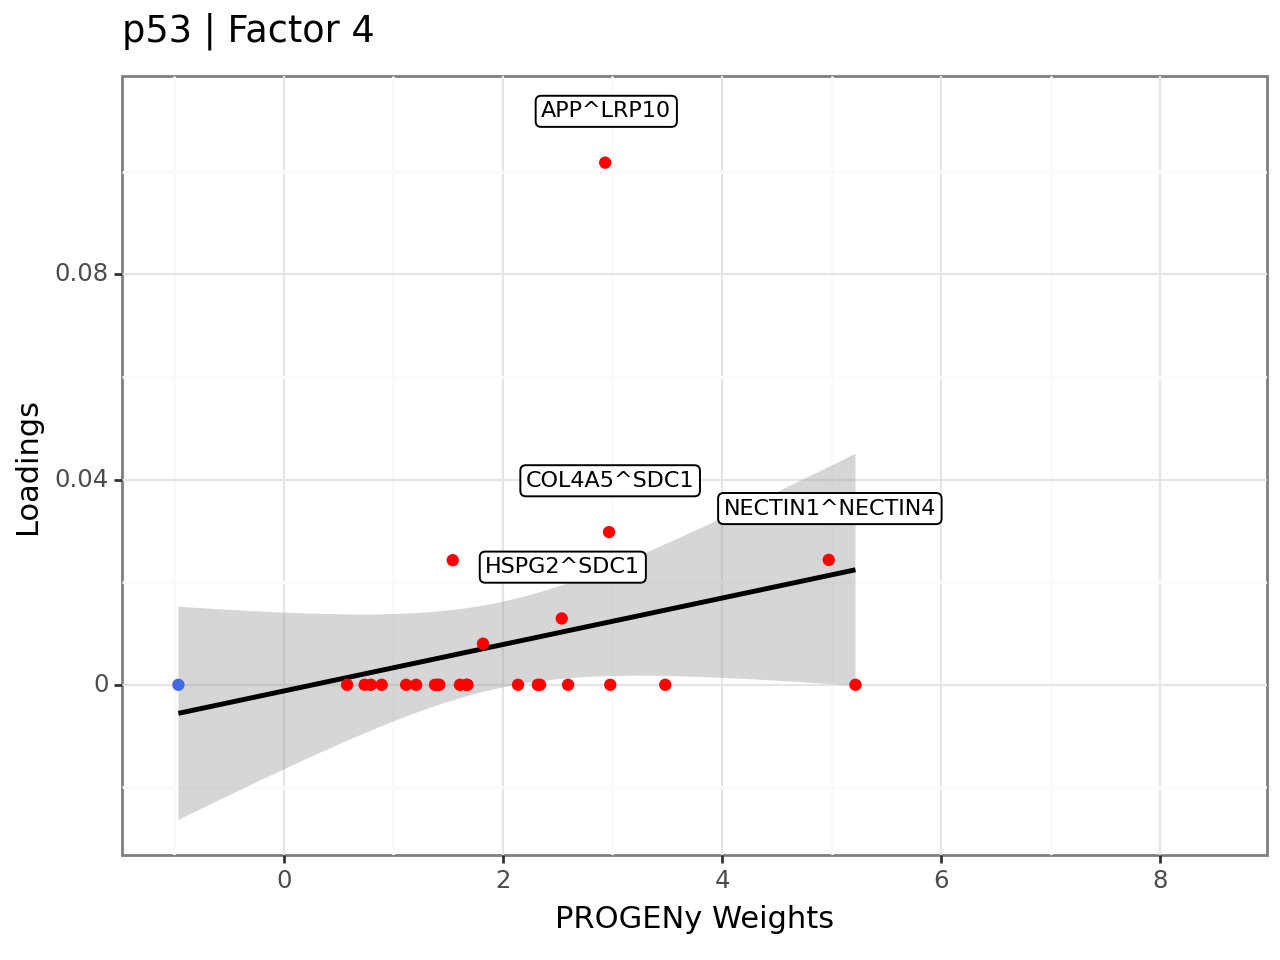

In [119]:
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")
condition = 'Healthy'
factor = 'Factor 4'
pathways = ['EGFR', 'Hypoxia', 'JAK-STAT', 'p53']
output_dir = figures_dir / 'factor_pathway_loadings'
for pathway in pathways:
    factor_pathway_loadings(
        tensor=tensor_dict[condition],
        condition=condition,
        pathway=pathway,
        factor=factor,
        lr_progeny=lr_progeny,
        save_file=output_dir / f'{condition}_{factor}_{pathway}_loadings.svg',
    )